In [13]:
import websocket
import json
import time
import pandas as pd
from IPython.display import clear_output
from datetime import datetime
import numpy as np

# Initialize a list to store all incoming messages
orderbook_rows = []

from datetime import datetime

def process_orderbook_message(data, ts):
    current_time_ms = int(time.time() * 1000)  # Convert to ms
    latency = current_time_ms - ts
    
    ts_human_readable = datetime.utcfromtimestamp(ts/1000).strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]

    best_bid_quantity = float(data['b'][0][1]) if data['b'] else 0
    best_ask_quantity = float(data['a'][0][1]) if data['a'] else 0
    
    # Calculate imbalance
    imbalance = best_bid_quantity - best_ask_quantity

    # Create a dictionary to store the data
    new_row = {
        "Timestamp": ts_human_readable,
        "Symbol": data["s"],
        "UpdateID": data["u"],
        "CrossSeq": data["seq"],
        "BestBidPrice": float(data['b'][0][0]) if data['b'] else None,
        "BestBidQuantity": best_bid_quantity,
        "BestAskPrice": float(data['a'][0][0]) if data['a'] else None,
        "BestAskQuantity": best_ask_quantity,
        "Latency": latency,
    }

    orderbook_rows.append(new_row)



def on_message(ws, message):
    clear_output(wait=True)
    message_dict = json.loads(message)
    if message_dict["topic"] == "orderbook.1.BTCUSDT":
        ts = message_dict["ts"]
        process_orderbook_message(message_dict["data"], ts)

def on_open(ws):
    subscribe_msg = {"op": "subscribe", "args": ["orderbook.1.BTCUSDT"]}
    ws.send(json.dumps(subscribe_msg))

url = "wss://stream.bybit.com/v5/public/linear"
ws = websocket.WebSocketApp(
    url,
    on_message=on_message,
    on_open=on_open
)

ws.run_forever()

False

In [ ]:
import matplotlib.pyplot as plt
x = 'PMO'
# Tracer les prix BestAskPrice et BestBidPrice par rapport au temps
plt.figure(figsize=(12, 6))
plt.plot(orderbook_history['Timestamp'], orderbook_history[x], label=x, color='blue', linestyle='-')
plt.title('Z_Score au fil du temps')
plt.xlabel('Temps')
plt.ylabel(x)
plt.grid(True)
plt.legend()
plt.show()


In [2]:
import numpy as np
import pandas as pd


# Convert the list of rows to a DataFrame after you stop the WebSocket
orderbook_history = pd.DataFrame(orderbook_rows)
# Forward fill NaN values
orderbook_history.fillna(method='ffill', inplace=True)
# Calculate additional columns based on the provided data

# Assuming orderbook_history DataFrame is defined (as in the given code)
# orderbook_history = pd.DataFrame(orderbook_rows)

# 1. Spread
orderbook_history["Spread"] = orderbook_history["BestAskPrice"] - orderbook_history["BestBidPrice"]

# 2. Moving average of Spread
orderbook_history["Spread_MA5"] = orderbook_history["Spread"].rolling(window=5).mean()

# 3. Volatility
orderbook_history["Return"] = orderbook_history["BestAskPrice"].pct_change()
orderbook_history["Volatility"] = orderbook_history["Return"].rolling(window=250).std()

# 4. Market trend using moving average
orderbook_history["Price_MA5"] = orderbook_history["BestAskPrice"].rolling(window=25).mean()

# 5. Buy/Sell pressure
orderbook_history["BuySellPressure"] = np.where(orderbook_history["BestAskQuantity"] != 0, orderbook_history["BestBidQuantity"] / orderbook_history["BestAskQuantity"], 0.0)


# Fill NaN values with forward-fill
orderbook_history.fillna(method='ffill', inplace=True)
# 8. Order book imbalance
orderbook_history["OrderBookImbalance"] = (orderbook_history["BestBidQuantity"] - orderbook_history["BestAskQuantity"]) / (orderbook_history["BestBidQuantity"] + orderbook_history["BestAskQuantity"])
orderbook_history.fillna(method='ffill', inplace=True)

# 9. Rate of change (using price for this example)
orderbook_history["PriceRateOfChange"] = orderbook_history["BestAskPrice"].diff()
orderbook_history.fillna(method='ffill', inplace=True)

# 10. Slippage (assuming slippage is the difference between consecutive best ask prices)
orderbook_history["Slippage"] = orderbook_history["BestAskPrice"].diff().shift(-1)
orderbook_history.fillna(method='ffill', inplace=True)

orderbook_history.drop(columns="Return", inplace=True)  # Drop the 'Return' column as it was only an intermediate step for volatility calculation
orderbook_history.fillna(method='ffill', inplace=True)

# 1. Moving Averages
orderbook_history["MA10"] = orderbook_history["BestAskPrice"].rolling(window=10).mean()
orderbook_history["MA20"] = orderbook_history["BestAskPrice"].rolling(window=20).mean()
orderbook_history["MA50"] = orderbook_history["BestAskPrice"].rolling(window=50).mean()
orderbook_history.fillna(method='ffill', inplace=True)
# 2. Momentum
orderbook_history["Momentum_5"] = orderbook_history["BestAskPrice"] - orderbook_history["BestAskPrice"].shift(5)
orderbook_history.fillna(method='ffill', inplace=True)
# 3. RSI
delta = orderbook_history["BestAskPrice"].diff()
gain = (delta.where(delta > 0, 0)).fillna(0)
loss = (-delta.where(delta < 0, 0)).fillna(0)
avg_gain = gain.rolling(window=140).mean()
avg_loss = loss.rolling(window=140).mean()
rs = avg_gain / avg_loss
orderbook_history["RSI"] = 100 - (100 / (1 + rs))
orderbook_history.fillna(method='ffill', inplace=True)
# 4. MACD
orderbook_history["MACD"] = orderbook_history["BestAskPrice"].ewm(span=12, adjust=False).mean() - orderbook_history["BestAskPrice"].ewm(span=26, adjust=False).mean()
orderbook_history["MACD_Signal"] = orderbook_history["MACD"].ewm(span=9, adjust=False).mean()
orderbook_history.fillna(method='ffill', inplace=True)
# 5. Bollinger Bands
orderbook_history["BB_Middle"] = orderbook_history["BestAskPrice"].rolling(window=200).mean()
orderbook_history["BB_Upper"] = orderbook_history["BB_Middle"] + 2*orderbook_history["BestAskPrice"].rolling(window=200).std()
orderbook_history["BB_Lower"] = orderbook_history["BB_Middle"] - 2*orderbook_history["BestAskPrice"].rolling(window=200).std()
orderbook_history.fillna(method='ffill', inplace=True)
# 6. Historical Highs/Lows
orderbook_history["Historical_High_5"] = orderbook_history["BestAskPrice"].rolling(window=500).max()
orderbook_history["Historical_Low_5"] = orderbook_history["BestAskPrice"].rolling(window=500).min()
orderbook_history.fillna(method='ffill', inplace=True)
# 7. Order Flow
orderbook_history["Order_Flow"] = orderbook_history["BestBidQuantity"] - orderbook_history["BestAskQuantity"]
orderbook_history.fillna(method='ffill', inplace=True)
# 8. Market Depth (already given as BestBidQuantity and BestAskQuantity)

# 9. Rate of Change of Volume
orderbook_history["Volume_ROC"] = orderbook_history["BestAskQuantity"].pct_change()
orderbook_history.fillna(method='ffill', inplace=True)
# 10. Percentage Price Oscillator (PPO)
orderbook_history["PPO"] = ((orderbook_history["BestAskPrice"].ewm(span=12, adjust=False).mean() - orderbook_history["BestAskPrice"].ewm(span=26, adjust=False).mean()) / orderbook_history["BestAskPrice"].ewm(span=26, adjust=False).mean()) * 100
orderbook_history.fillna(method='ffill', inplace=True)
# 11. Stochastic Oscillator
low_14 = orderbook_history["BestAskPrice"].rolling(window=140).min()
high_14 = orderbook_history["BestAskPrice"].rolling(window=140).max()
orderbook_history["Stochastic_Oscillator"] = 100 * ((orderbook_history["BestAskPrice"] - low_14) / (high_14 - low_14))
orderbook_history.fillna(method='ffill', inplace=True)
# 12. ATR
orderbook_history["ATR"] = orderbook_history["BestAskPrice"].diff().rolling(window=500).mean()
orderbook_history.fillna(method='ffill', inplace=True)
# 13. Price-to-Volume Ratio
orderbook_history["Price_to_Volume"] = orderbook_history["BestAskPrice"] / orderbook_history["BestAskQuantity"]
orderbook_history.fillna(method='ffill', inplace=True)
# 14. Liquidity Measures (BestBidQuantity and BestAskQuantity are already there)

# Adding new features to the DataFrame

# 1. VWAP
orderbook_history["VWAP"] = (orderbook_history["BestAskPrice"] * orderbook_history["BestAskQuantity"]).cumsum() / orderbook_history["BestAskQuantity"].cumsum()
orderbook_history.fillna(method='ffill', inplace=True)
# 2. Historical Volatility
orderbook_history["Historical_Volatility"] = orderbook_history["BestAskPrice"].pct_change().rolling(window=200).std()
orderbook_history.fillna(method='ffill', inplace=True)
# 3. Price Momentum Oscillator (PMO)
# PPO: handle division by zero
denominator = orderbook_history["BestAskPrice"].ewm(span=26, adjust=False).mean()
orderbook_history["PMO"] = np.where(denominator != 0, ((orderbook_history["BestAskPrice"].ewm(span=12, adjust=False).mean() - denominator) / denominator) * 100, 0.0)

# ADX: handle division by zero
positive_move = orderbook_history["BestAskPrice"].diff().where(orderbook_history["BestAskPrice"].diff() > 0, 0)
negative_move = -orderbook_history["BestAskPrice"].diff().where(orderbook_history["BestAskPrice"].diff() < 0, 0)
positive_dm_avg = positive_move.rolling(window=140).mean()
negative_dm_avg = negative_move.rolling(window=140).mean()
denom = positive_dm_avg + negative_dm_avg
orderbook_history["ADX"] = np.where(denom != 0, 100 * abs(positive_dm_avg - negative_dm_avg) / denom, 0.0)
# 5. CMF (Chaikin Money Flow)
mf_multiplier = ((orderbook_history["BestAskPrice"] - orderbook_history["BestAskPrice"].rolling(window=20).min()) - 
                 (orderbook_history["BestAskPrice"].rolling(window=200).max() - orderbook_history["BestAskPrice"])) / \
                (orderbook_history["BestAskPrice"].rolling(window=200).max() - orderbook_history["BestAskPrice"].rolling(window=20).min())
mf_volume = mf_multiplier * orderbook_history["BestAskQuantity"]
orderbook_history["CMF"] = mf_volume.rolling(window=20).sum() / orderbook_history["BestAskQuantity"].rolling(window=200).sum()
orderbook_history.fillna(method='ffill', inplace=True)
# 6. Z-Score
orderbook_history["Z_Score"] = (orderbook_history["BestAskPrice"] - orderbook_history["BestAskPrice"].rolling(window=200).mean()) / orderbook_history["BestAskPrice"].rolling(window=200).std()
orderbook_history.fillna(method='ffill', inplace=True)
# 7. Price and Volume Trend (PVT)
orderbook_history["PVT"] = (orderbook_history["BestAskPrice"].pct_change() * orderbook_history["BestAskQuantity"]).cumsum()
orderbook_history.fillna(method='ffill', inplace=True)
# 8. Ease of Movement (EoM)
price_diff = orderbook_history["BestAskPrice"].diff().shift(-1)
box_ratio = (orderbook_history["BestAskQuantity"] / (orderbook_history["BestAskPrice"].rolling(window=2).max() - orderbook_history["BestAskPrice"].rolling(window=2).min()))
orderbook_history["EoM"] = price_diff / box_ratio
orderbook_history.fillna(method='ffill', inplace=True)
# Convert 'Timestamp' column to datetime format
orderbook_history["Timestamp"] = pd.to_datetime(orderbook_history["Timestamp"])
orderbook_history.fillna(method='ffill', inplace=True)
# Recalculate 'Time_Since_Last_Trade' using the datetime format
orderbook_history["Time_Since_Last_Trade"] = orderbook_history["Timestamp"].diff().fillna(pd.Timedelta(seconds=0))
orderbook_history.fillna(method='ffill', inplace=True)
# Convert the timedelta to seconds for easier processing
orderbook_history["Time_Since_Last_Trade"] = orderbook_history["Time_Since_Last_Trade"].dt.total_seconds()
orderbook_history.fillna(method='ffill', inplace=True)
orderbook_history["LargeBids"] = (orderbook_history["BestBidQuantity"] > orderbook_history["BestBidQuantity"].quantile(0.95)).astype(int)
orderbook_history["LargeAsks"] = (orderbook_history["BestAskQuantity"] > orderbook_history["BestAskQuantity"].quantile(0.95)).astype(int)

# Handle NaN values once at the end
orderbook_history.fillna(method='ffill', inplace=True)
orderbook_history.fillna(method='bfill', inplace=True)  # For the initial rows where ffill won't work

pd.set_option('display.max_columns', None)

print(orderbook_history)


                     Timestamp   Symbol  UpdateID     CrossSeq  BestBidPrice  \
0      2023-10-03 03:57:17.728  BTCUSDT  36808384  87408010746       27581.3   
1      2023-10-03 03:57:18.018  BTCUSDT  36808385  87408010966       27581.3   
2      2023-10-03 03:57:18.258  BTCUSDT  36808386  87408011131       27581.3   
3      2023-10-03 03:57:18.367  BTCUSDT  36808387  87408011202       27581.3   
4      2023-10-03 03:57:18.417  BTCUSDT  36808388  87408011236       27581.3   
...                        ...      ...       ...          ...           ...   
688626 2023-10-03 13:36:57.617  BTCUSDT  37497010  87505930476       27497.8   
688627 2023-10-03 13:36:57.628  BTCUSDT  37497011  87505930538       27497.8   
688628 2023-10-03 13:36:57.637  BTCUSDT  37497012  87505930594       27497.8   
688629 2023-10-03 13:36:57.647  BTCUSDT  37497013  87505930619       27497.8   
688630 2023-10-03 13:36:57.677  BTCUSDT  37497014  87505930688       27497.8   

        BestBidQuantity  BestAskPrice  

In [ ]:
print(orderbook_history)

In [ ]:
import matplotlib.pyplot as plt

# Tracer les prix BestAskPrice et BestBidPrice par rapport au temps
plt.figure(figsize=(12, 6))
plt.plot(orderbook_history['Timestamp'], orderbook_history['BestAskPrice'], label='BestAskPrice', color='blue', linestyle='-')
plt.plot(orderbook_history['Timestamp'], orderbook_history['BestBidPrice'], label='BestBidPrice', color='red', linestyle='--')
plt.title('Évolution des prix BestAskPrice et BestBidPrice au fil du temps')
plt.xlabel('Temps')
plt.ylabel('Prix')
plt.grid(True)
plt.legend()
plt.show()



In [ ]:
import matplotlib.pyplot as plt

# Tracer les prix BestAskPrice et BestBidPrice par rapport au temps
plt.figure(figsize=(12, 6))
plt.plot(orderbook_history['Timestamp'], orderbook_history['Spread'], label='Spread', color='blue', linestyle='-')
plt.title('Évolution des prix Spread au fil du temps')
plt.xlabel('Temps')
plt.ylabel('Prix')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Supprimez les valeurs NaN du spread
spread_data = orderbook_history["Order_Flow"].dropna()

# Créez un histogramme pour visualiser la distribution du spread
plt.figure(figsize=(10, 6))
plt.hist(spread_data, bins=50, density=True, alpha=0.6, color='b', edgecolor='k')
plt.title('Distribution du Order_Flow ')
plt.xlabel('Order_Flow ')
plt.ylabel('Densité')
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
x = 'Volatility'
# Tracer les prix BestAskPrice et BestBidPrice par rapport au temps
plt.figure(figsize=(12, 6))
plt.plot(orderbook_history['Timestamp'], orderbook_history[x], label='x', color='blue', linestyle='-')
plt.title('Évolution de la Volatility au fil du temps')
plt.xlabel('Temps')
plt.ylabel(x)
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
x = 'Imbalance'
# Tracer les prix BestAskPrice et BestBidPrice par rapport au temps
plt.figure(figsize=(12, 6))
plt.plot(orderbook_history['Timestamp'], orderbook_history[x], label=x, color='blue', linestyle='-')
plt.title('Évolution de la Imbalance au fil du temps')
plt.xlabel('Temps')
plt.ylabel(x)
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
x = 'BestBidQuantity'
y = 'BestAskQuantity'
# Tracer les prix BestAskPrice et BestBidPrice par rapport au temps
plt.figure(figsize=(12, 6))
plt.plot(orderbook_history['Timestamp'], orderbook_history[x], label=x, color='blue', linestyle='-')
plt.plot(orderbook_history['Timestamp'], orderbook_history[y], label=y, color='orange', linestyle='-')

plt.title('Évolution de la BestQuantity au fil du temps')
plt.xlabel('Temps')
plt.ylabel(x)
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
BuySellPressure

In [ ]:
import matplotlib.pyplot as plt
x = 'Slippage'
# Tracer les prix BestAskPrice et BestBidPrice par rapport au temps
plt.figure(figsize=(12, 6))
plt.plot(orderbook_history['Timestamp'], orderbook_history[x], label=x, color='blue', linestyle='-')
plt.title('Évolution de la Slippage au fil du temps')
plt.xlabel('Temps')
plt.ylabel(x)
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
x = 'RSI'
# Tracer les prix BestAskPrice et BestBidPrice par rapport au temps
plt.figure(figsize=(12, 6))
plt.plot(orderbook_history['Timestamp'], orderbook_history[x], label=x, color='blue', linestyle='-')
plt.title('Évolution RSI au fil du temps')
plt.xlabel('Temps')
plt.ylabel(x)
plt.grid(True)
plt.legend()
plt.show()


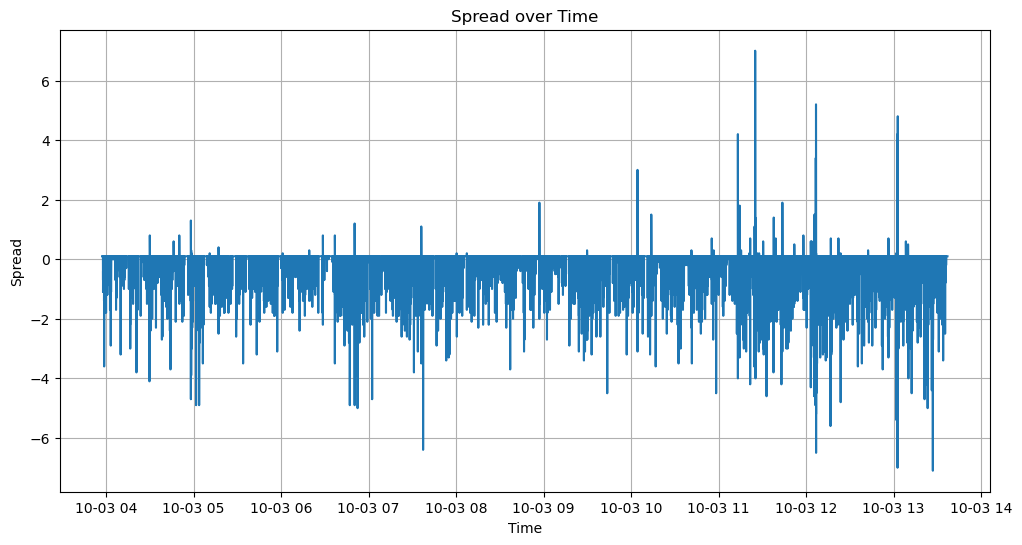

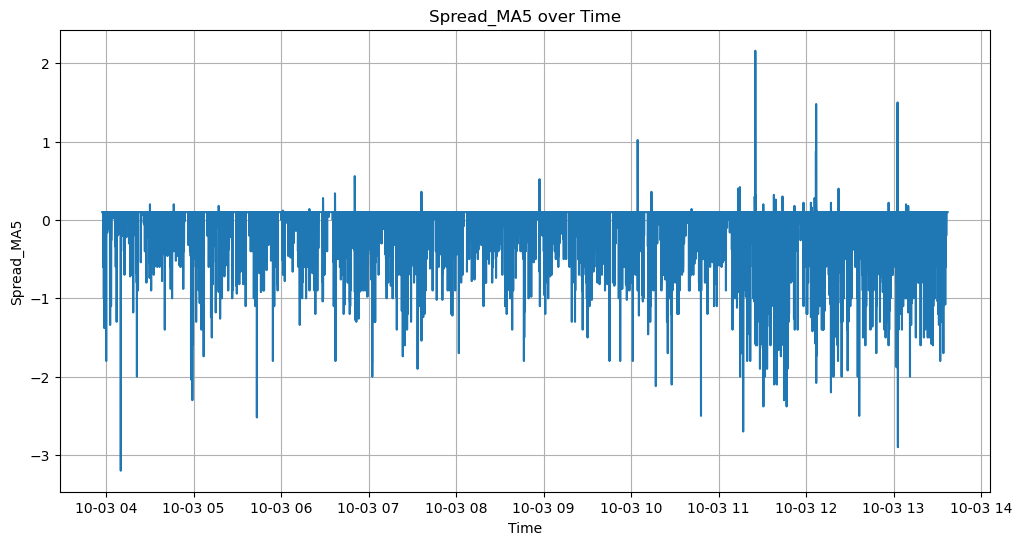

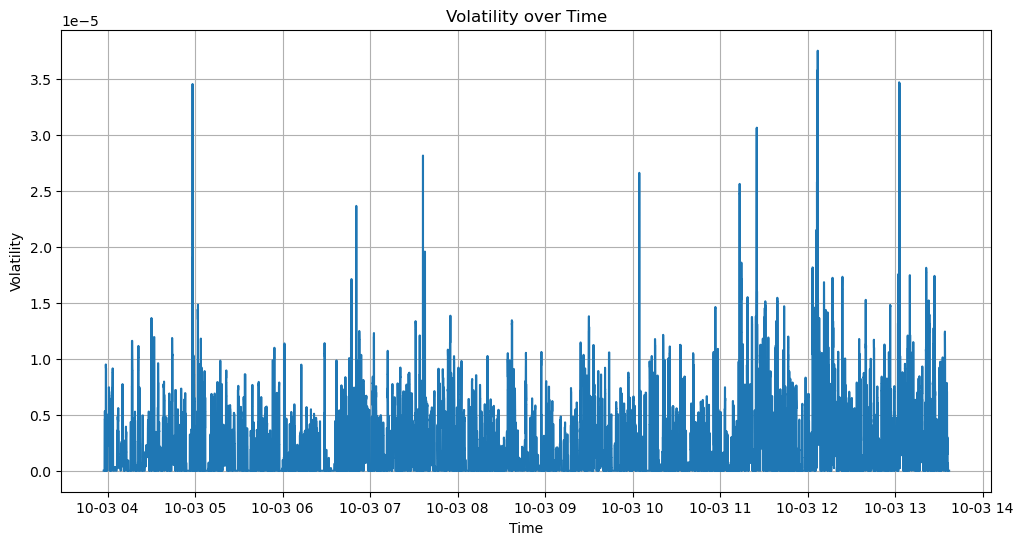

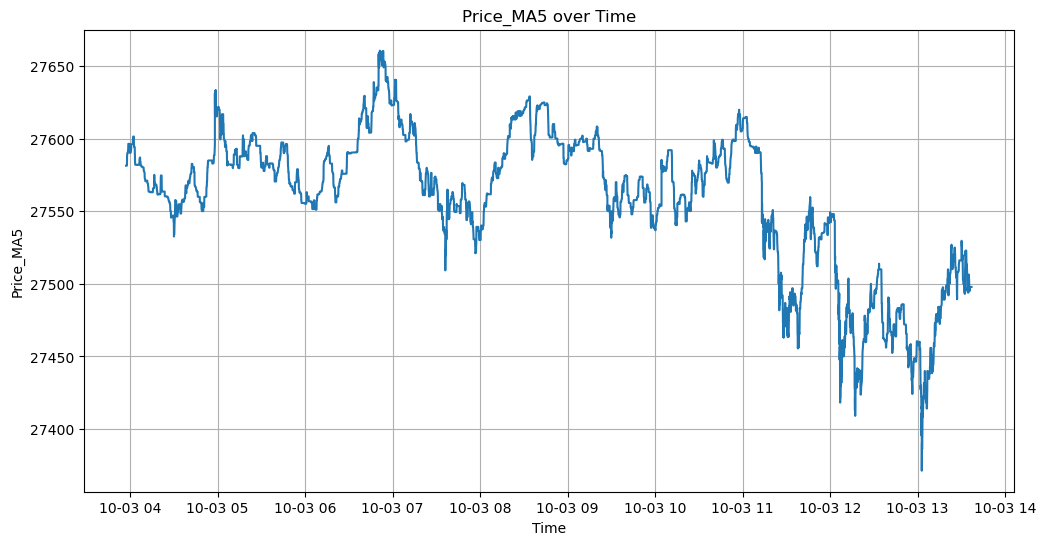

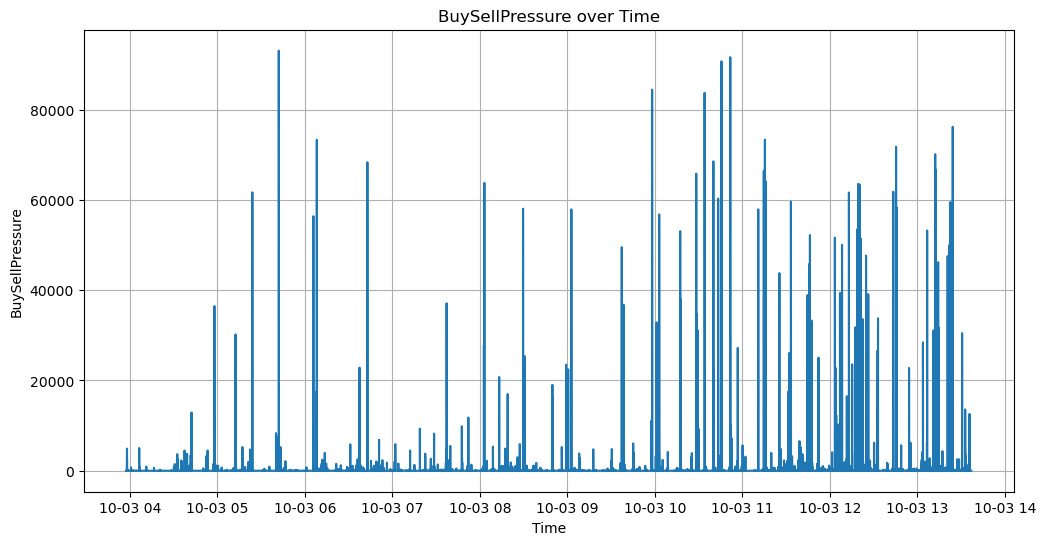

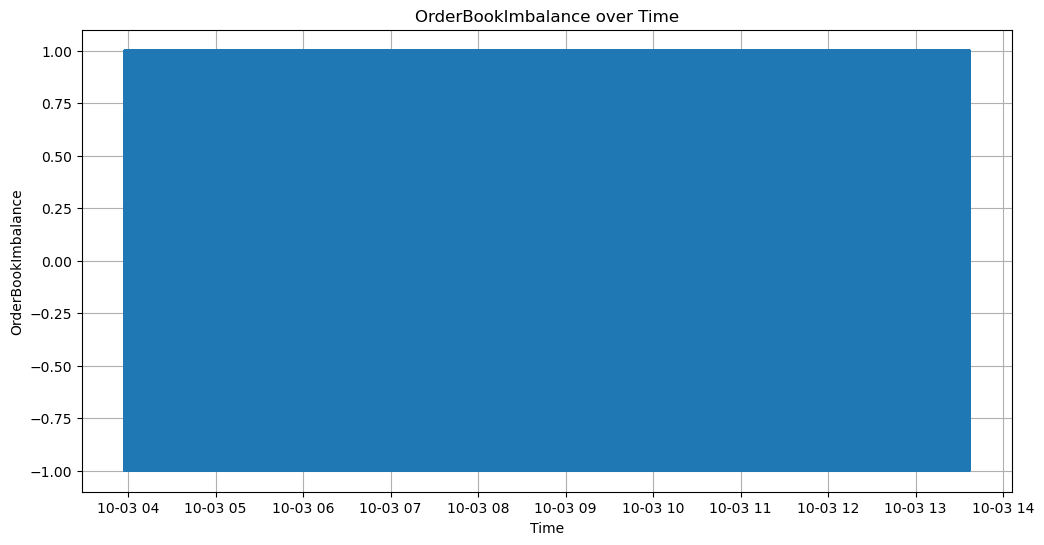

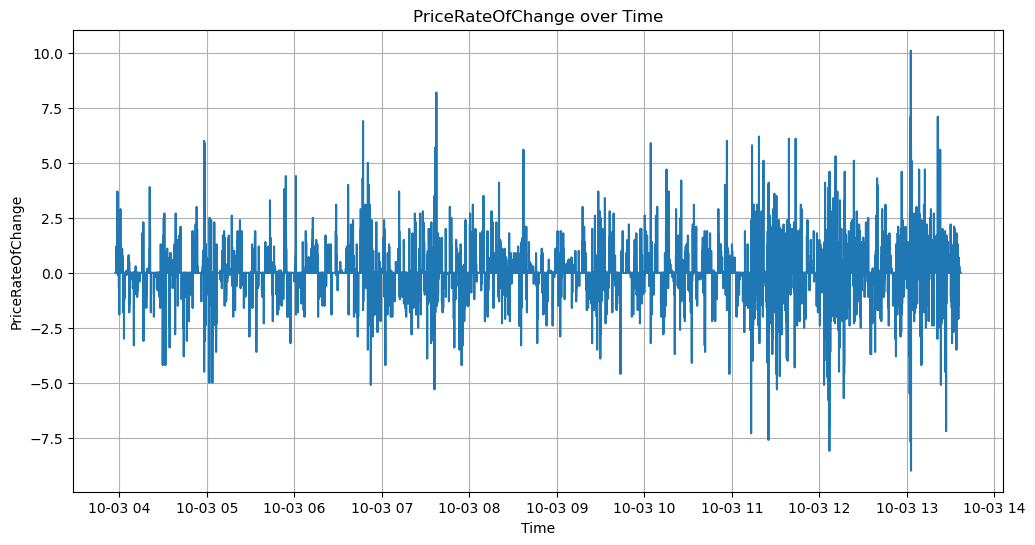

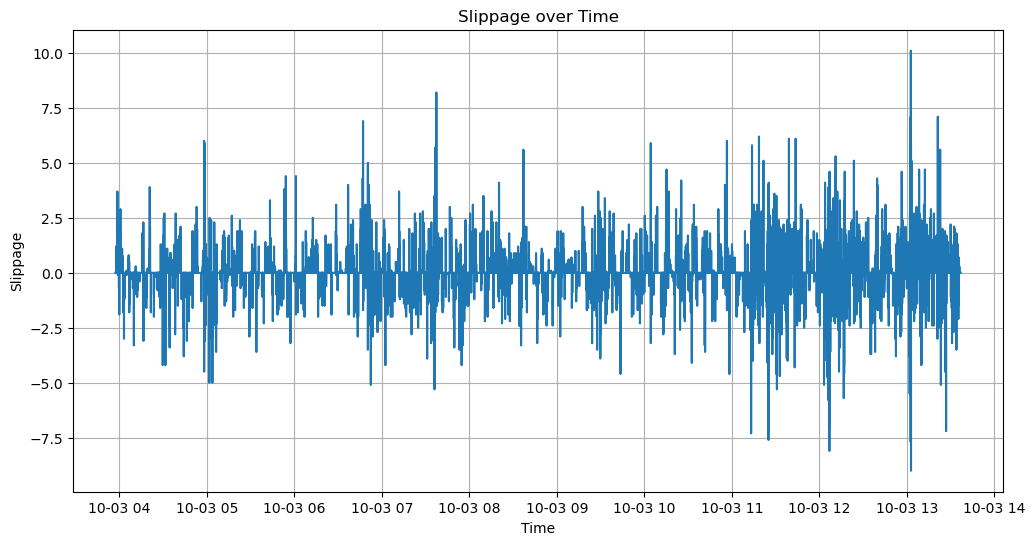

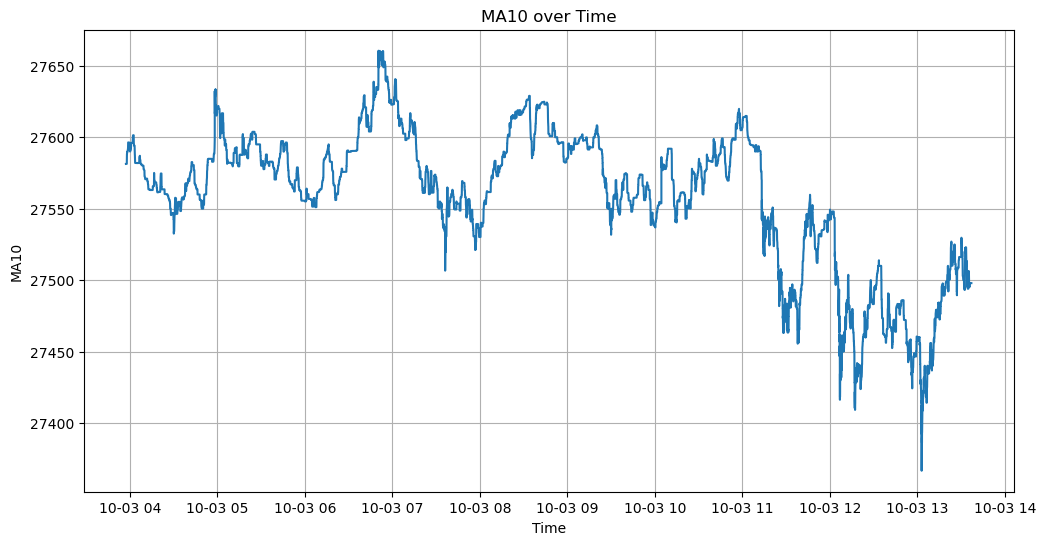

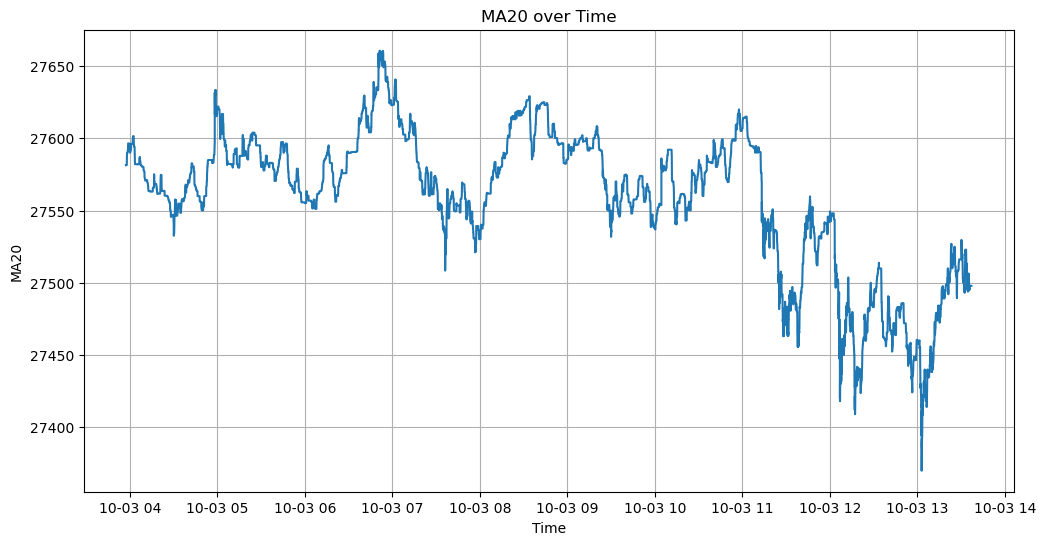

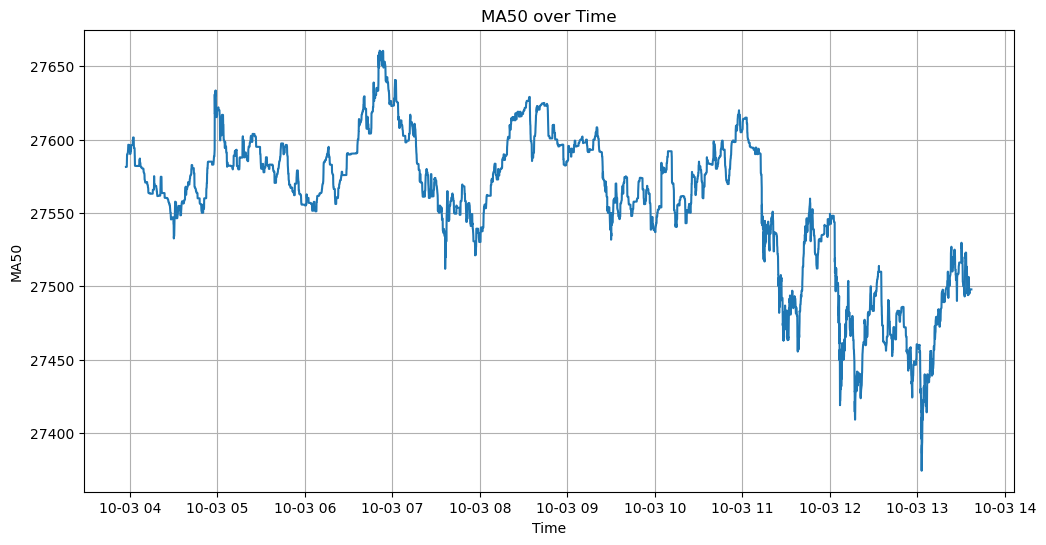

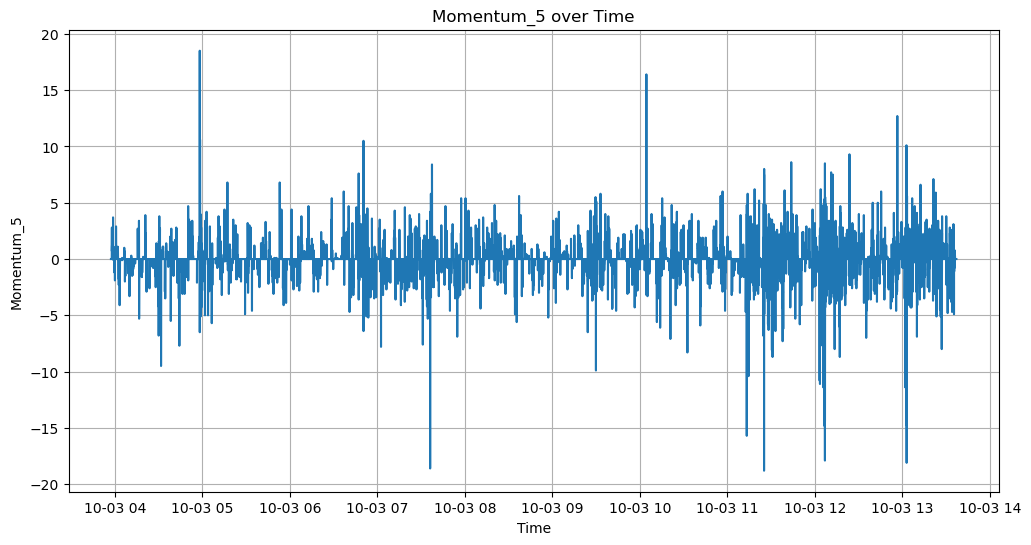

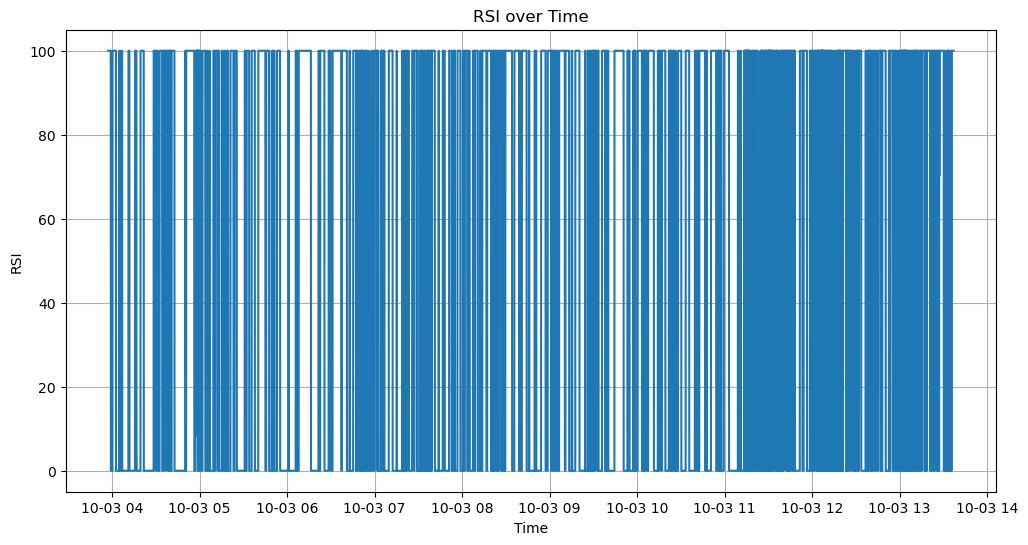

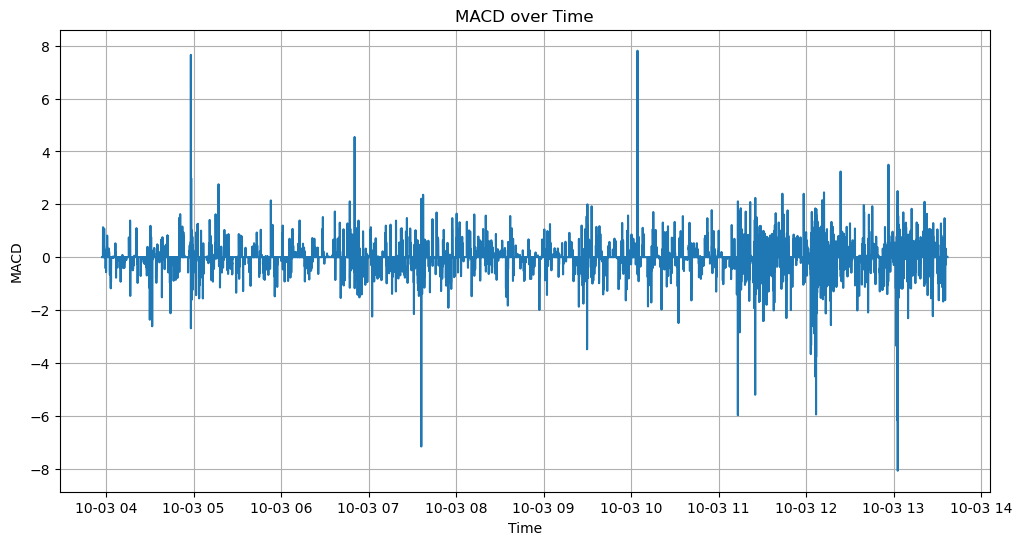

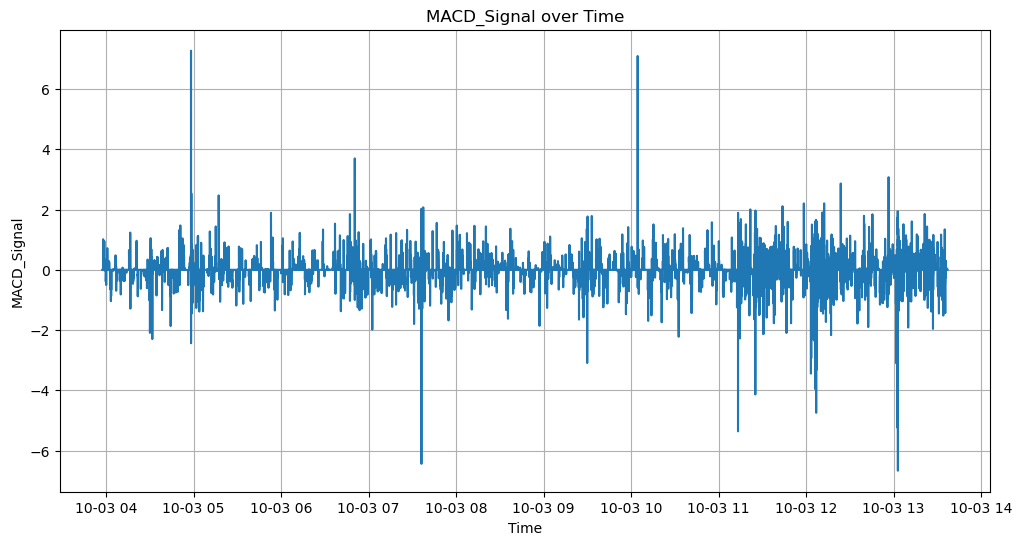

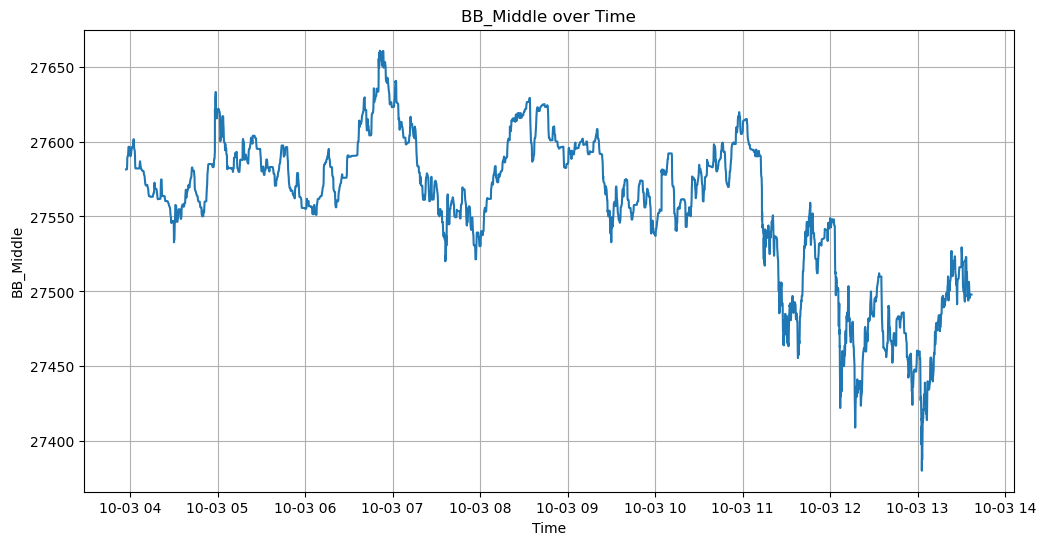

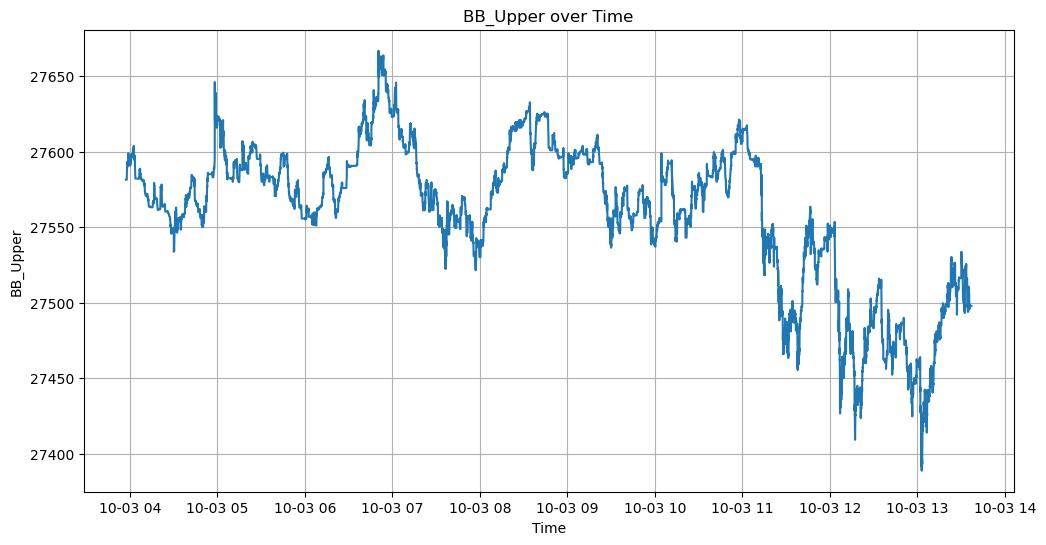

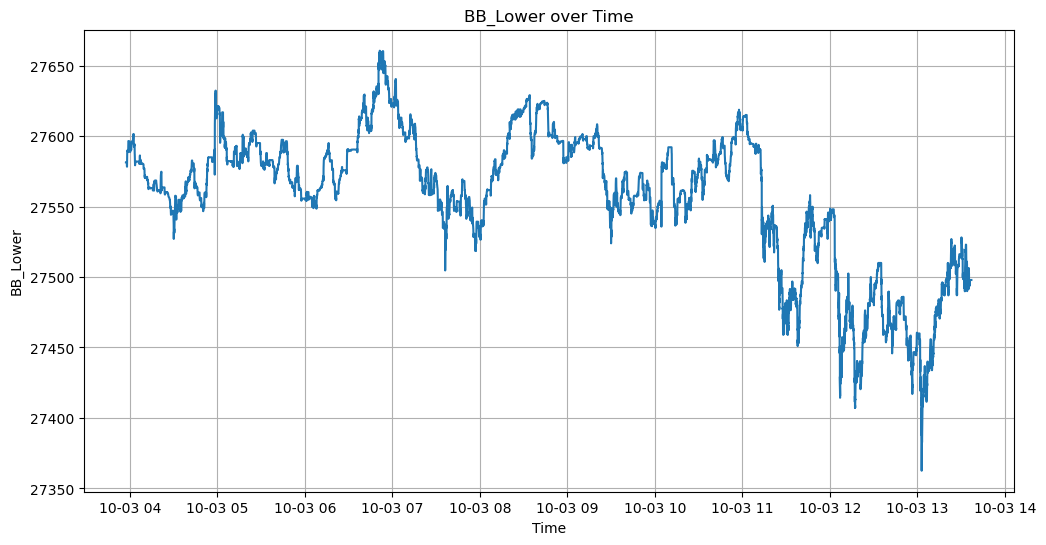

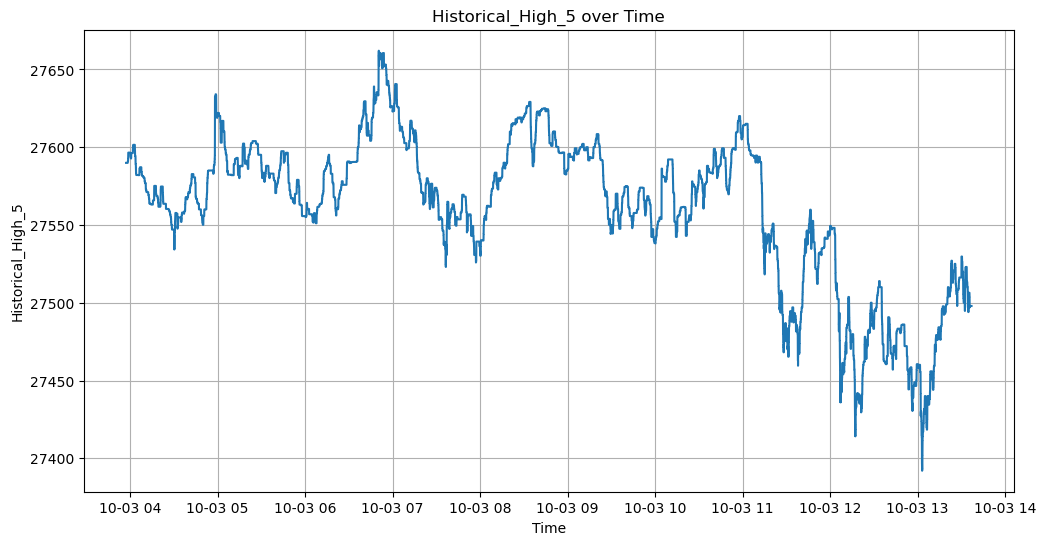

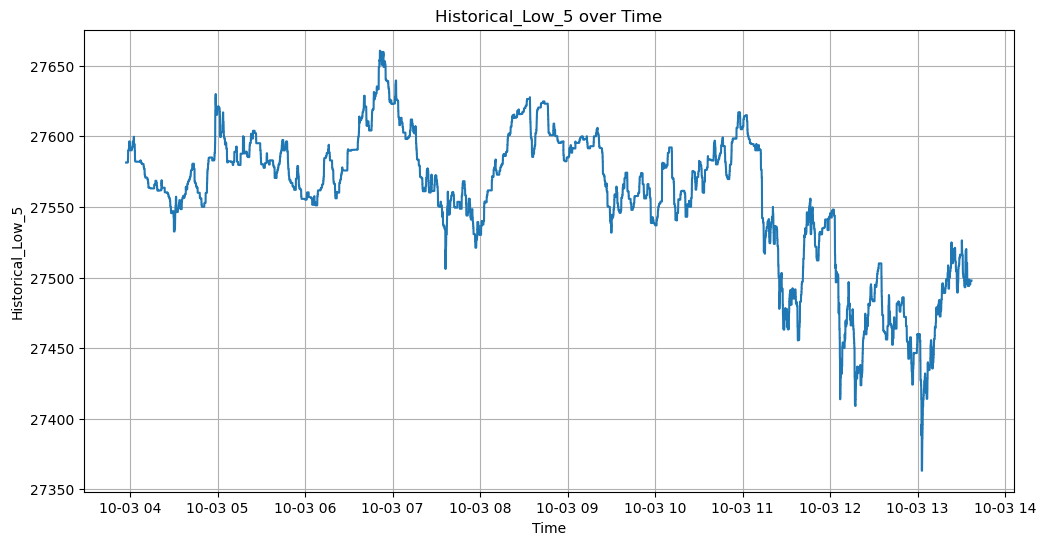

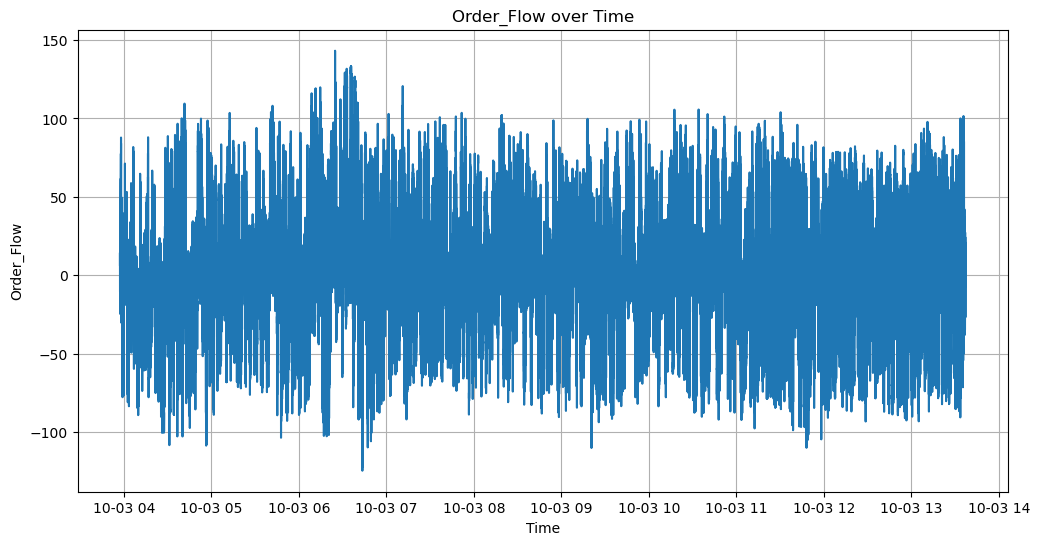

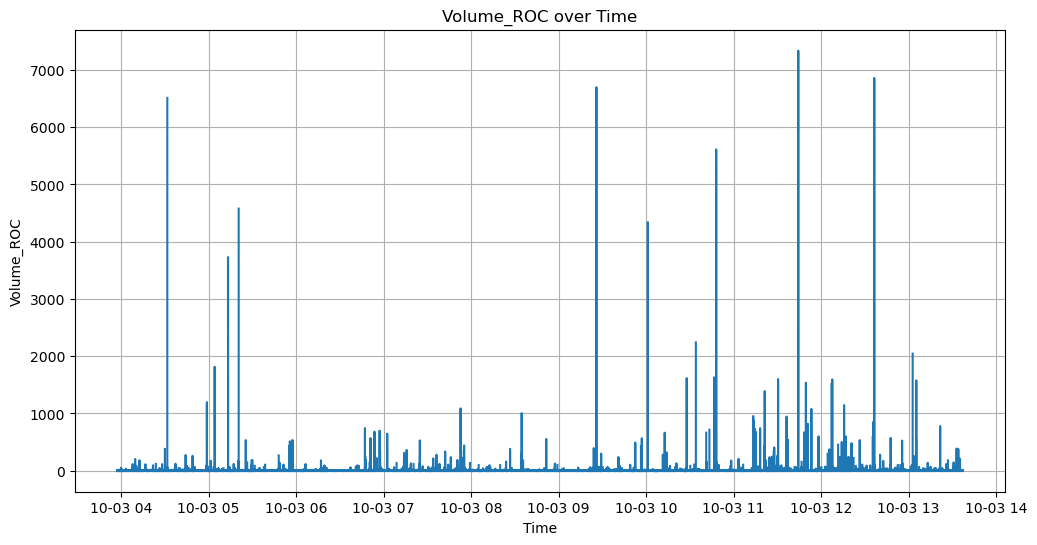

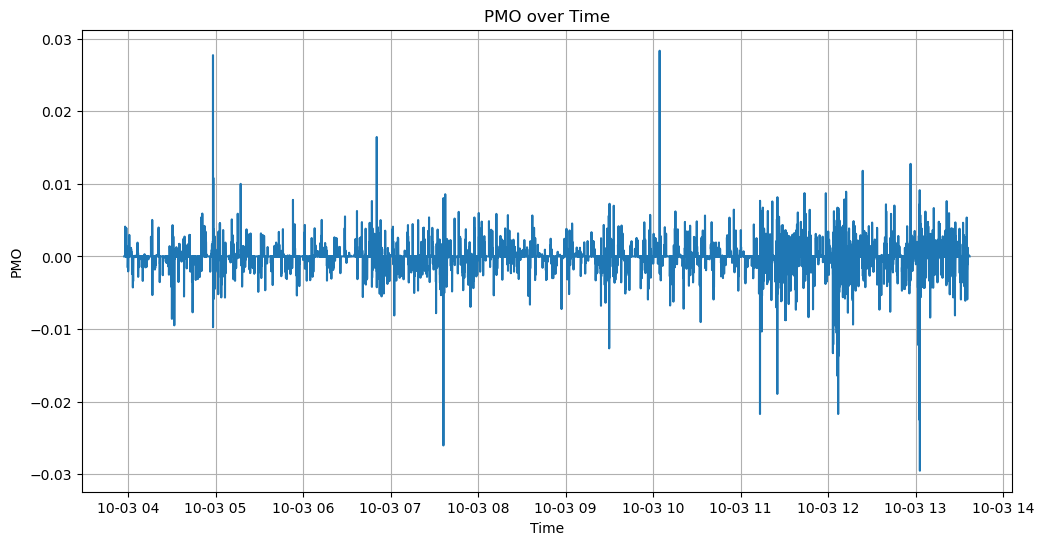

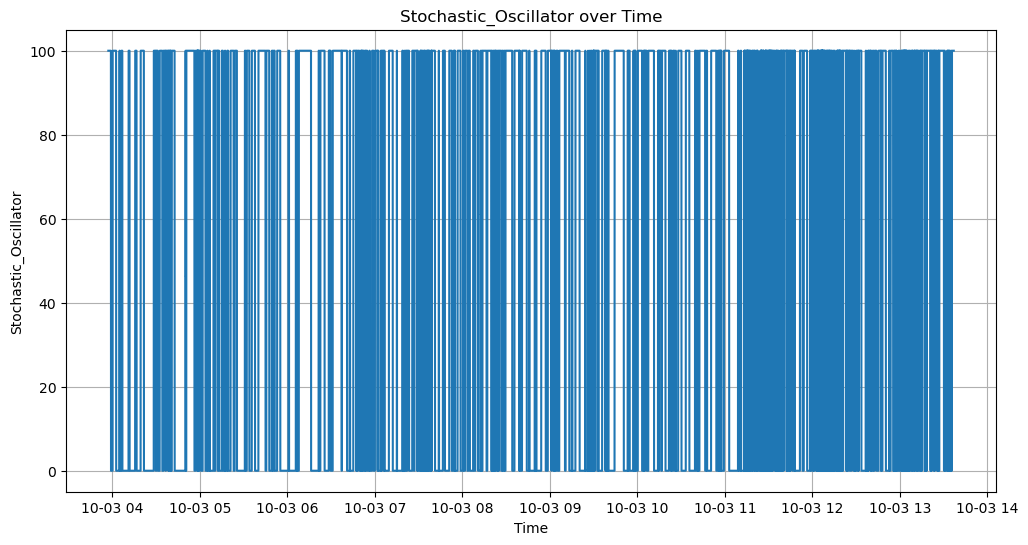

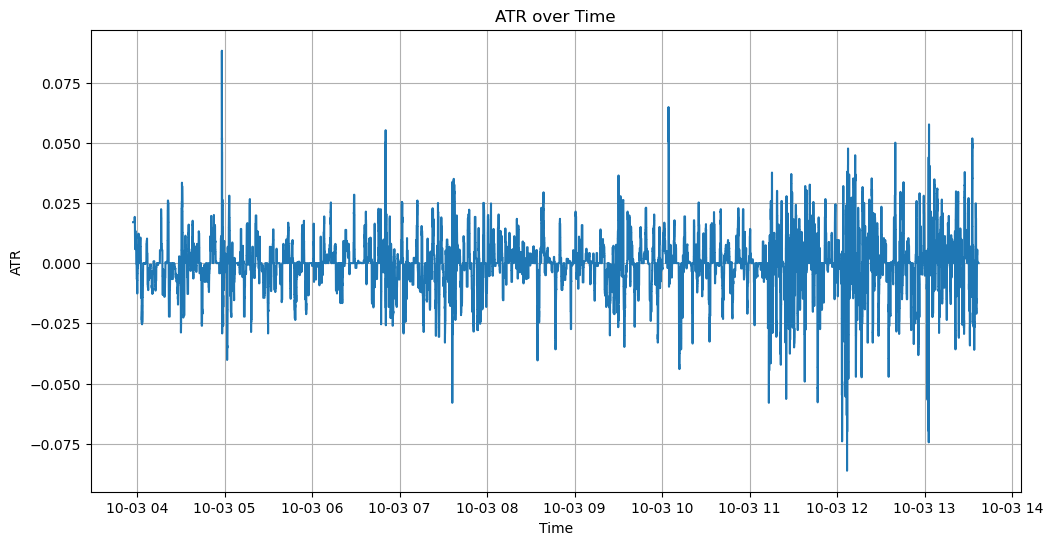

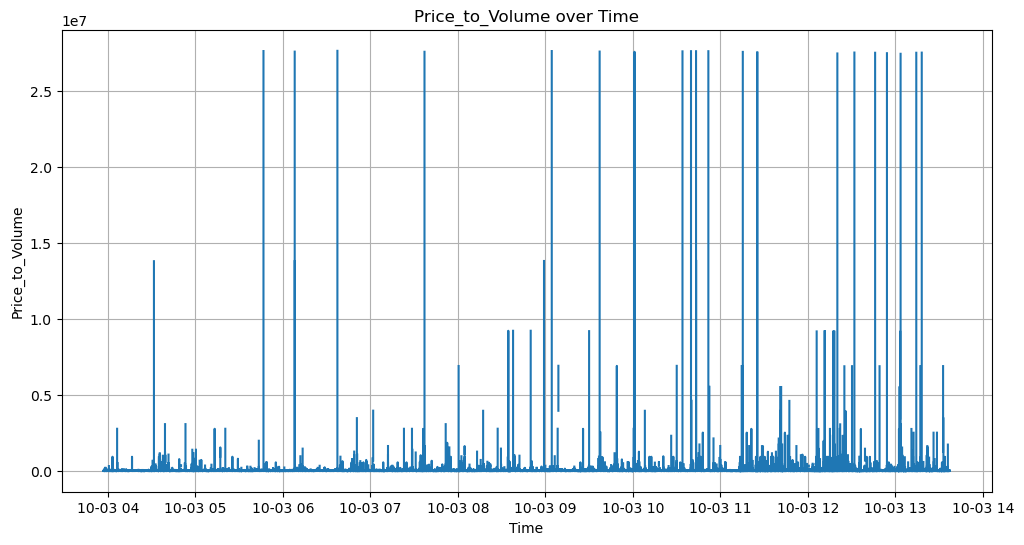

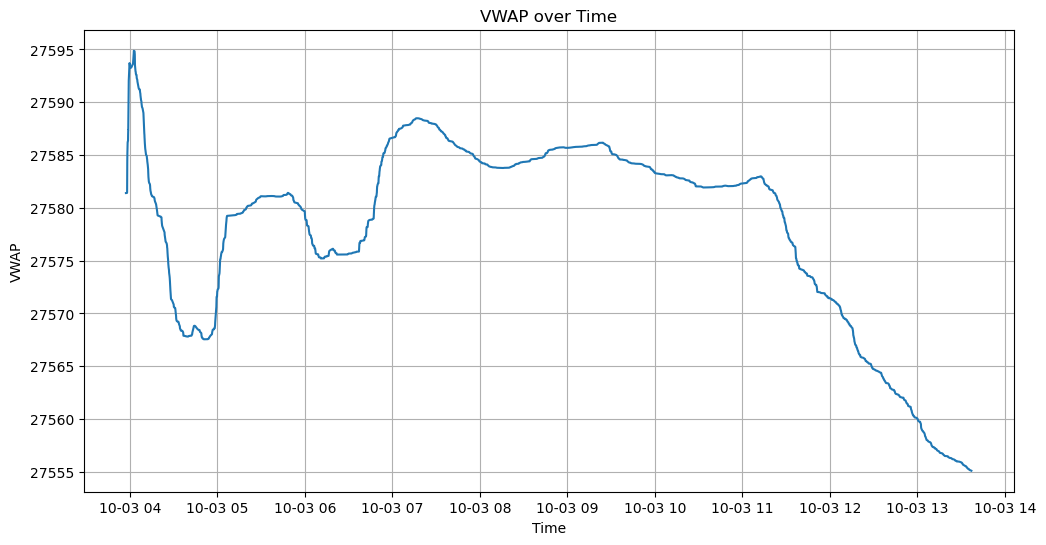

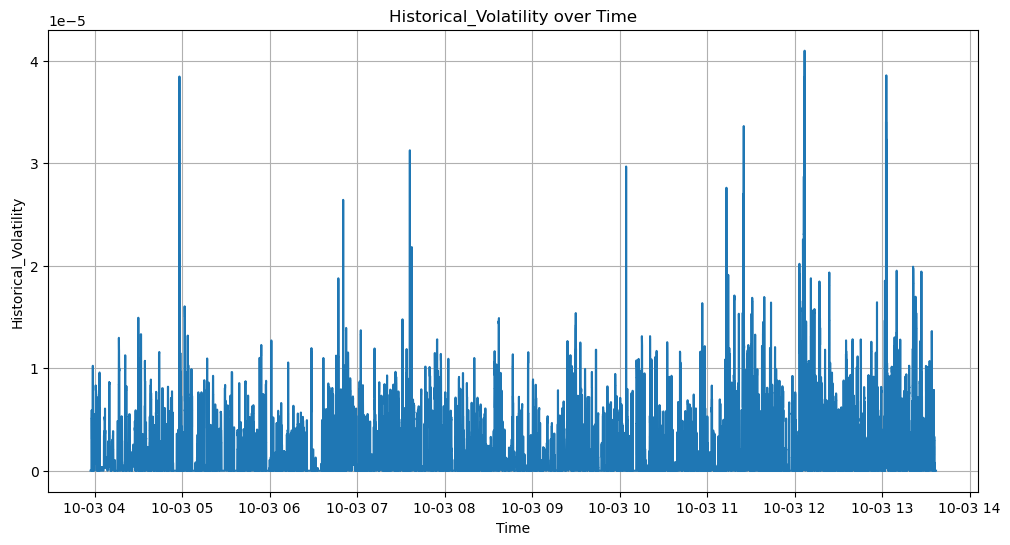

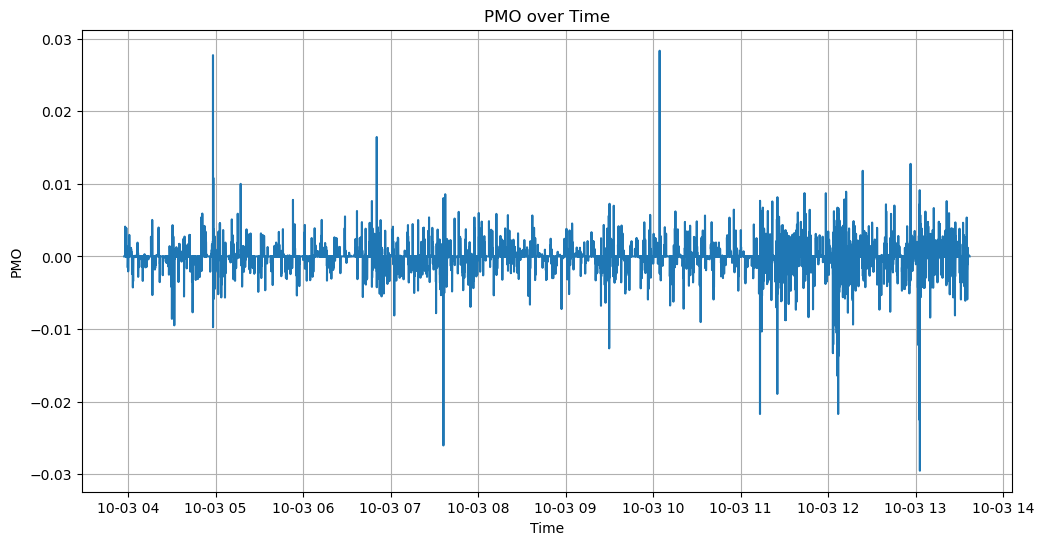

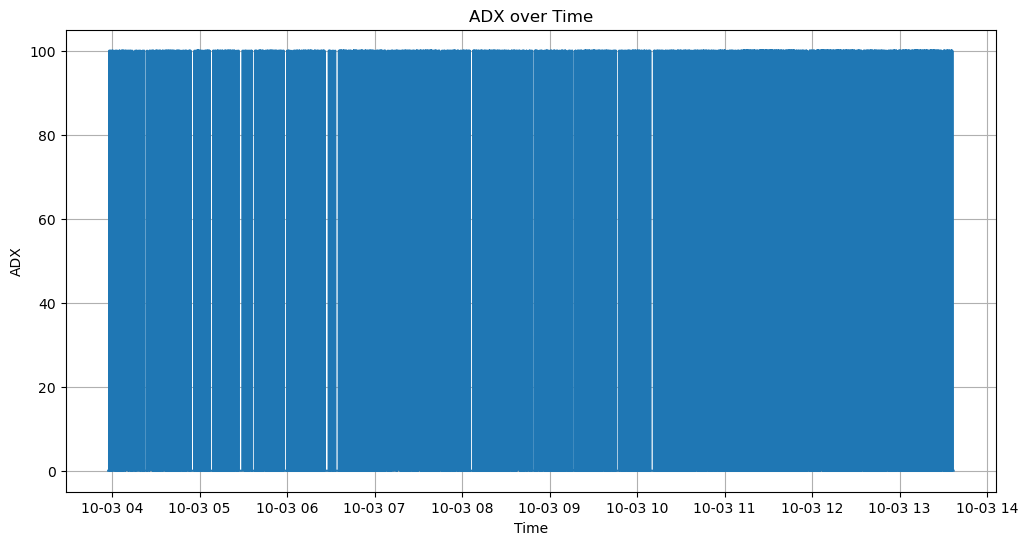

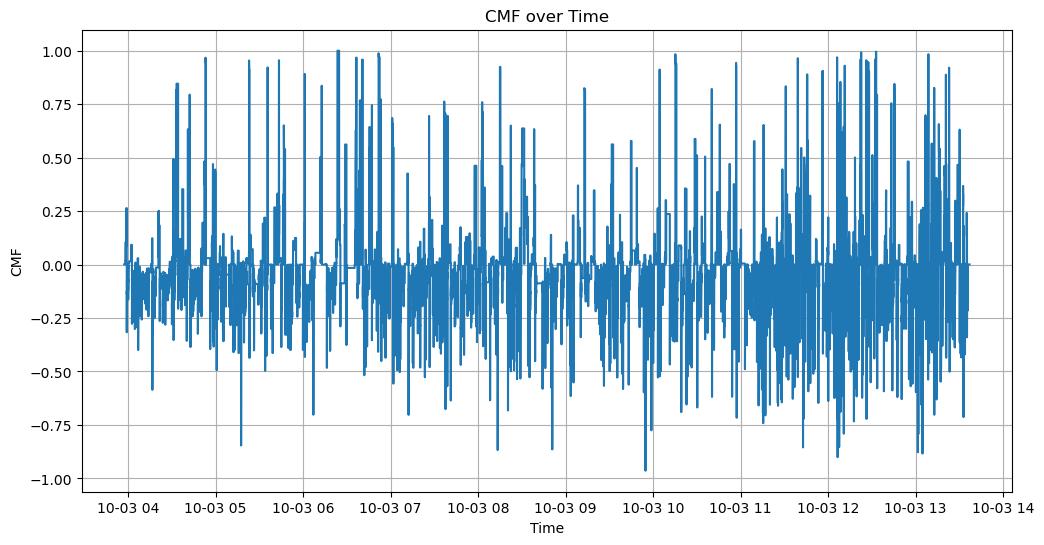

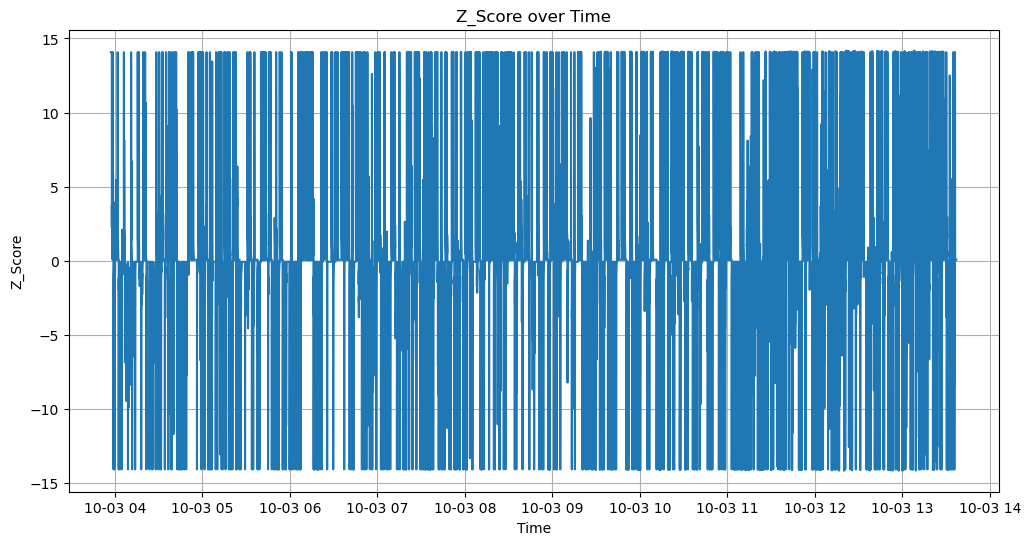

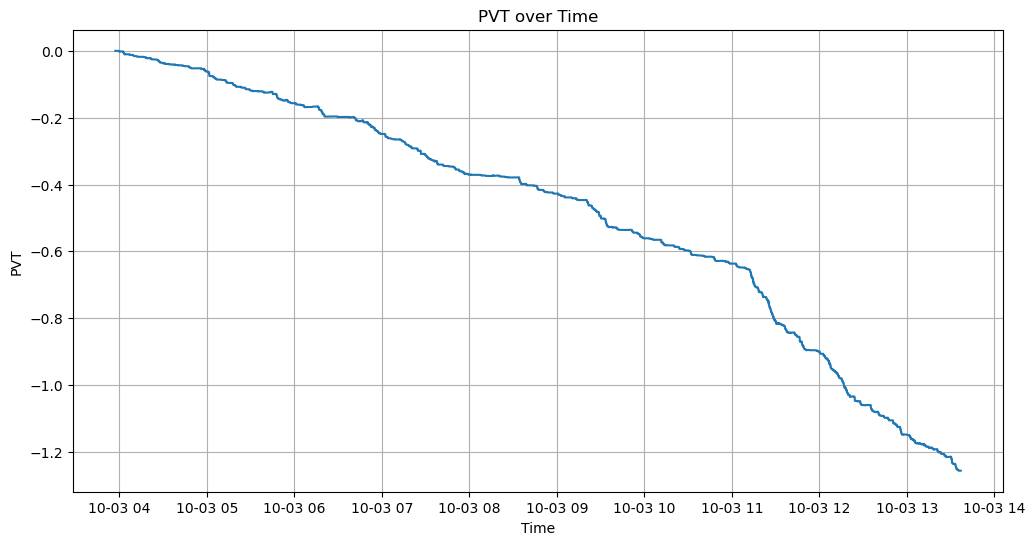

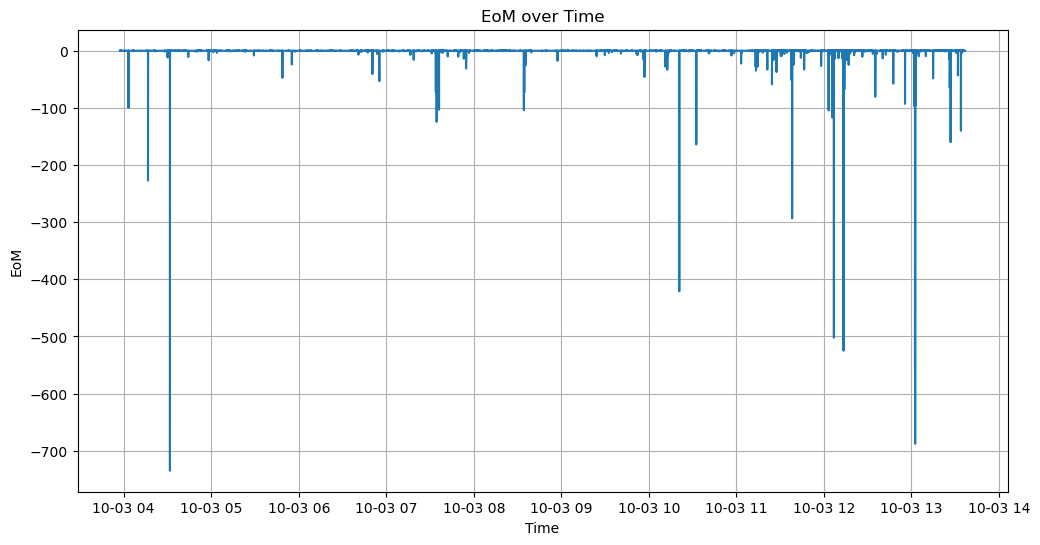

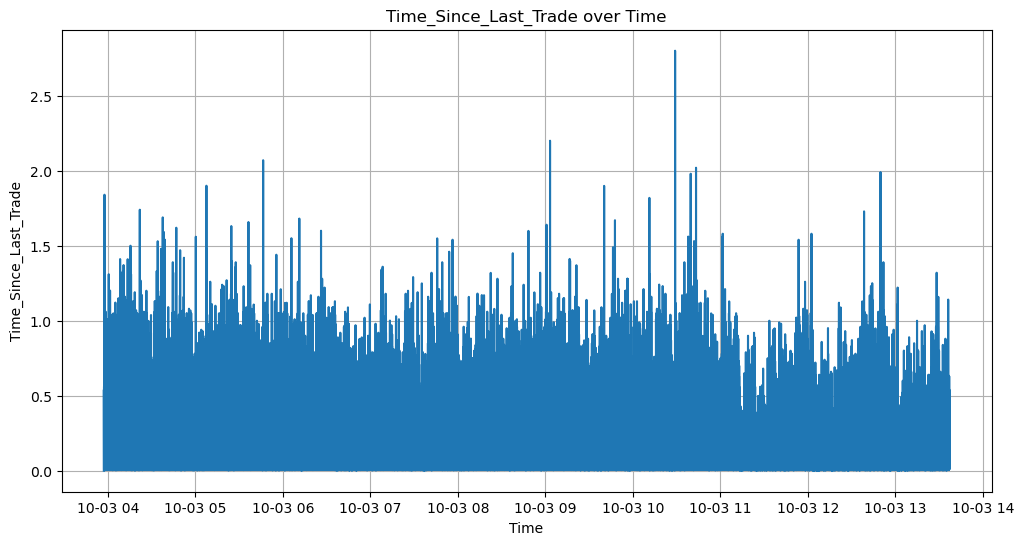

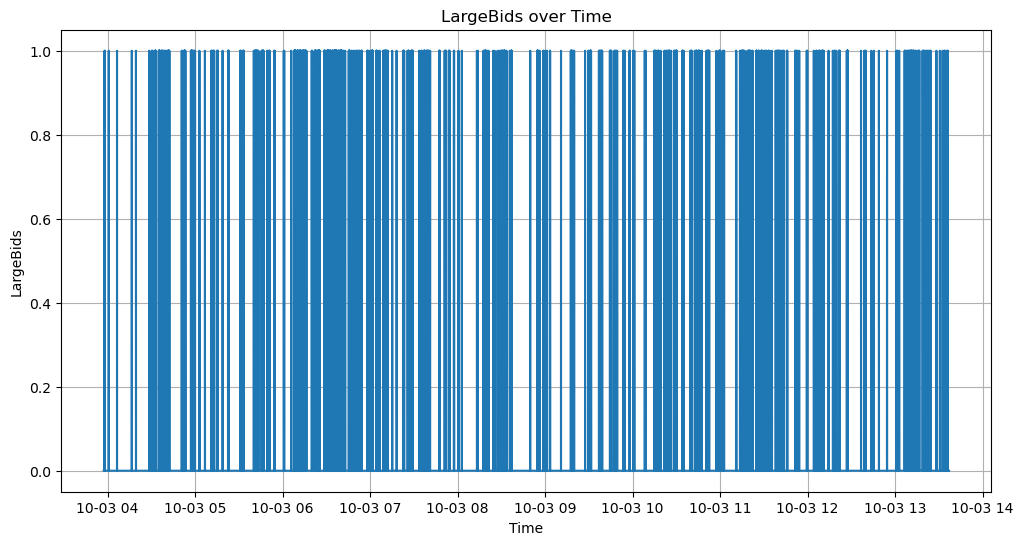

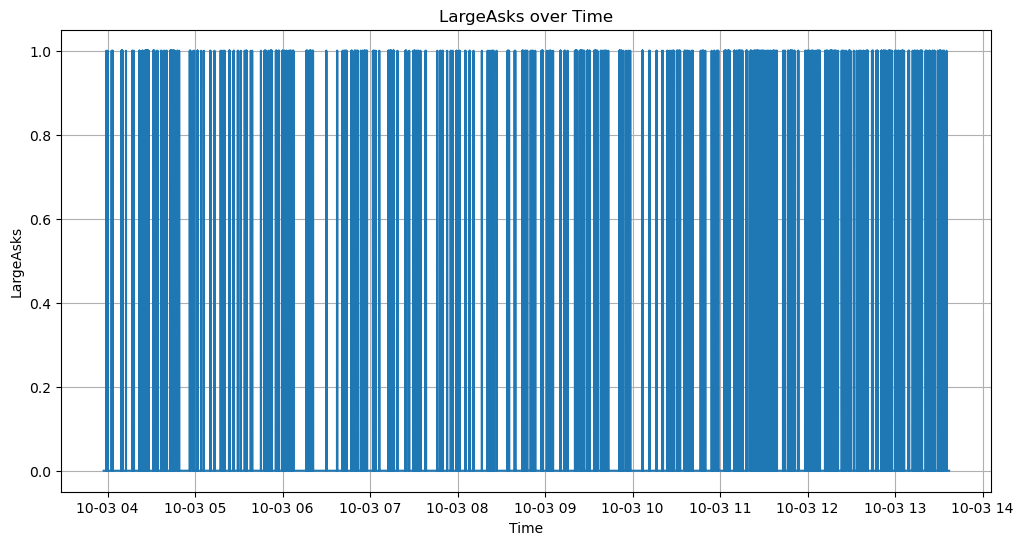

In [3]:
import matplotlib.pyplot as plt

# Liste des noms de fonctionnalités
features = [
    "Spread", "Spread_MA5", "Volatility", "Price_MA5", "BuySellPressure", 
    "OrderBookImbalance", "PriceRateOfChange", "Slippage", "MA10", "MA20", 
    "MA50", "Momentum_5", "RSI", "MACD", "MACD_Signal", "BB_Middle", 
    "BB_Upper", "BB_Lower", "Historical_High_5", "Historical_Low_5", 
    "Order_Flow", "Volume_ROC", "PMO", "Stochastic_Oscillator", "ATR", 
    "Price_to_Volume", "VWAP", "Historical_Volatility", "PMO", "ADX", 
    "CMF", "Z_Score", "PVT", "EoM", "Time_Since_Last_Trade", "LargeBids", 
    "LargeAsks"
]

# Boucle pour créer et afficher des graphiques pour chaque fonctionnalité
for feature in features:
    plt.figure(figsize=(12, 6))
    plt.plot(orderbook_history["Timestamp"], orderbook_history[feature])
    plt.title(f"{feature} over Time")
    plt.xlabel("Time")
    plt.ylabel(feature)
    plt.grid(True)
    plt.show()


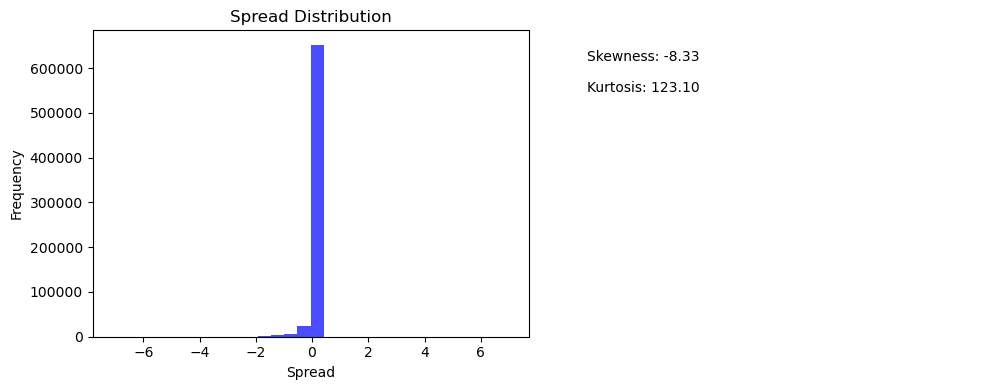

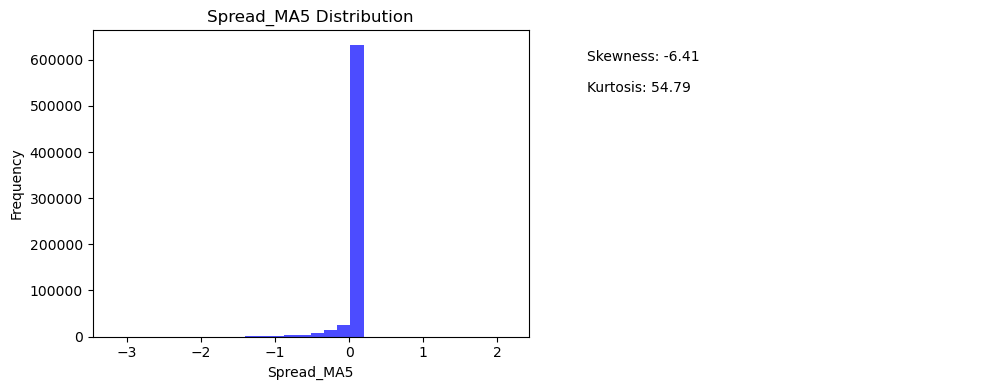

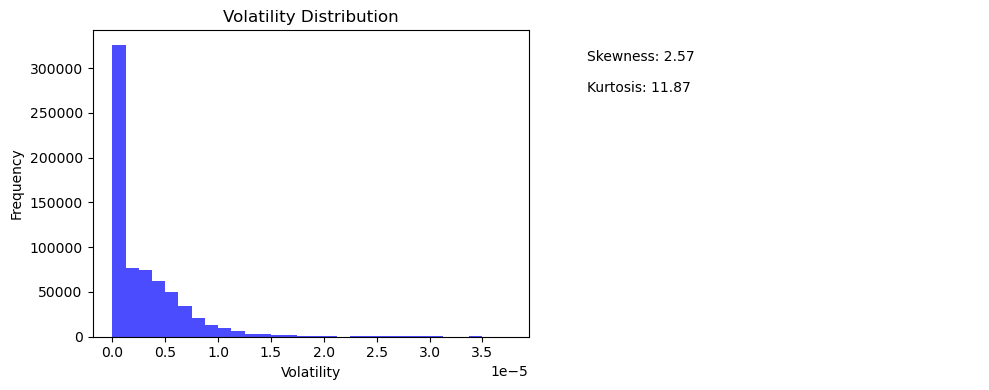

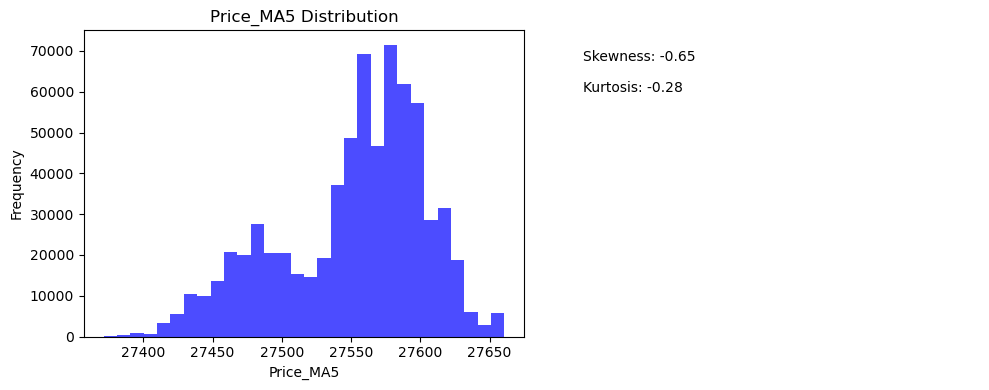

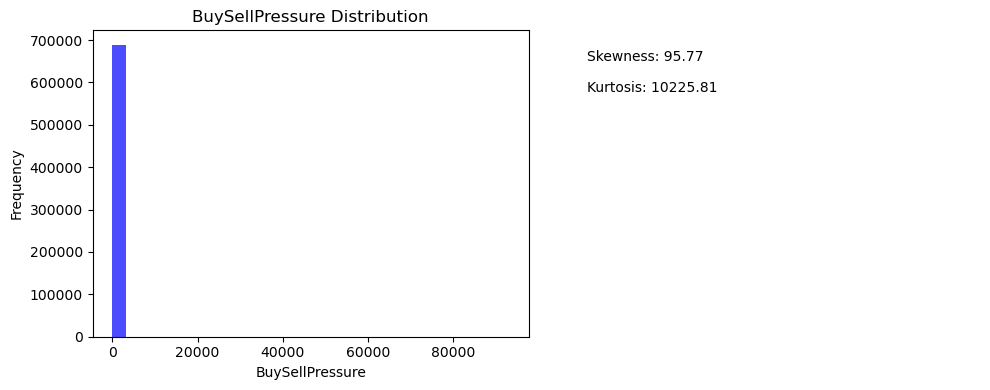

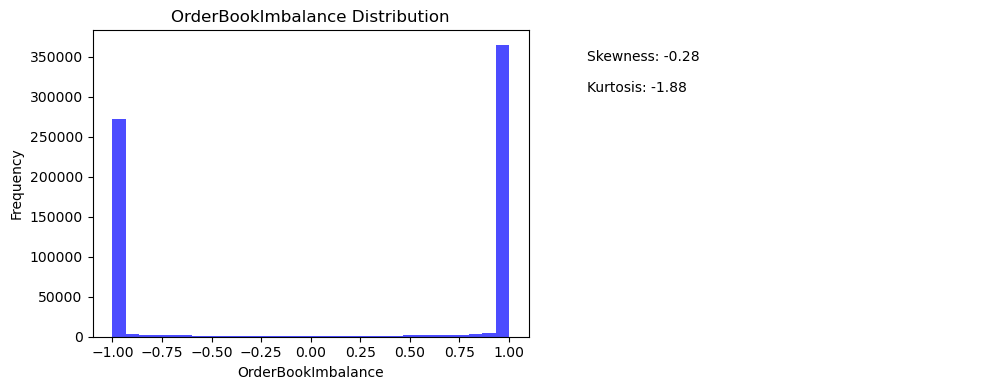

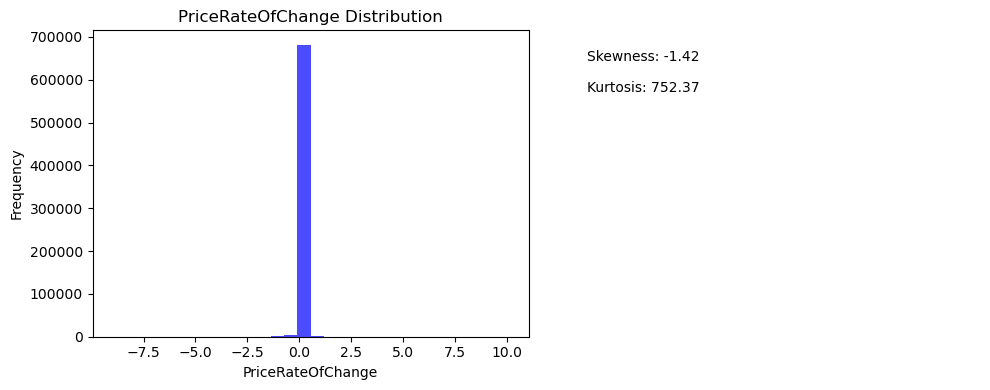

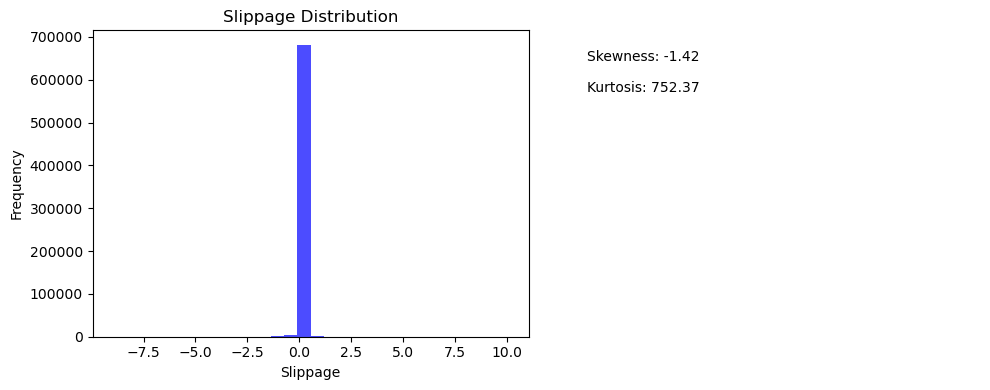

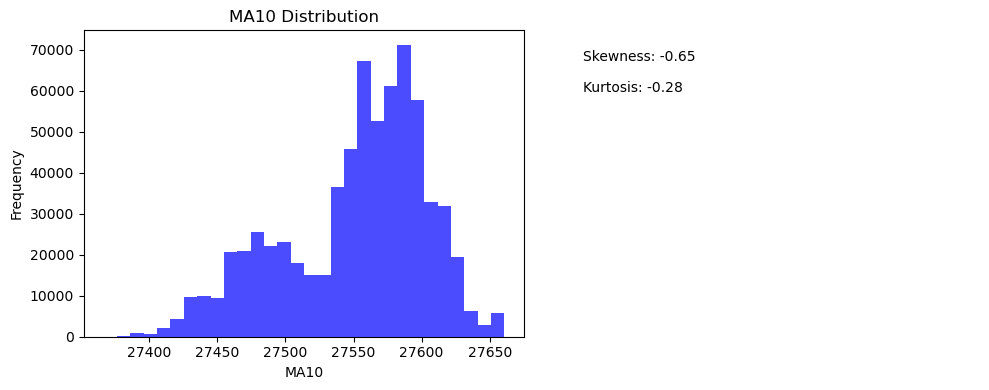

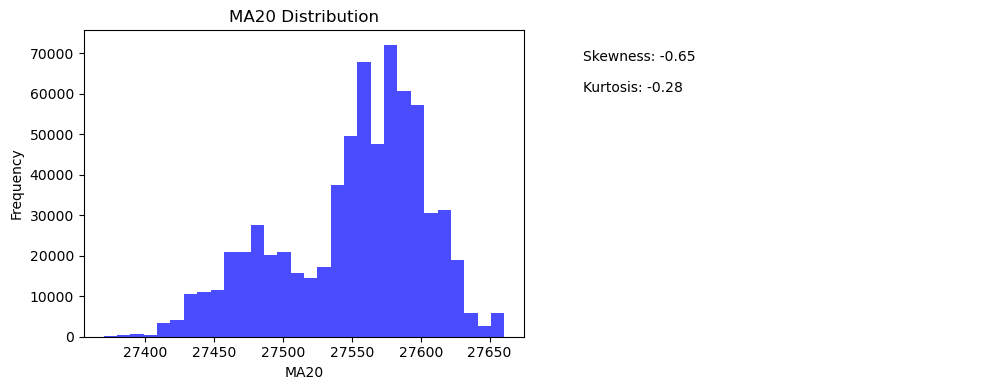

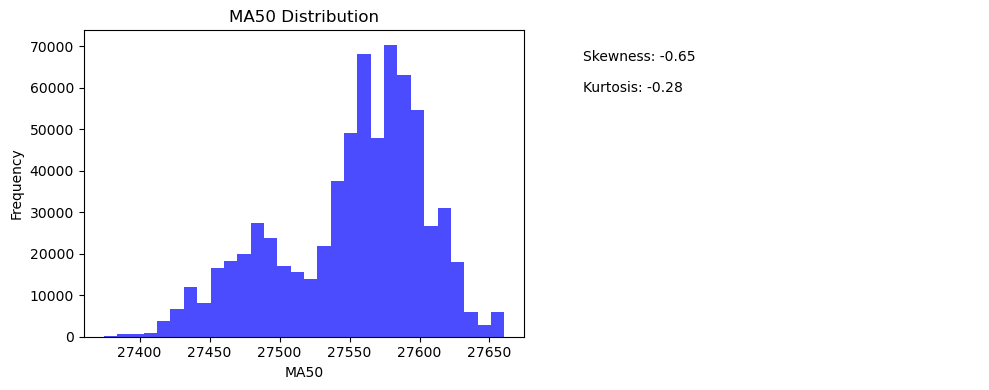

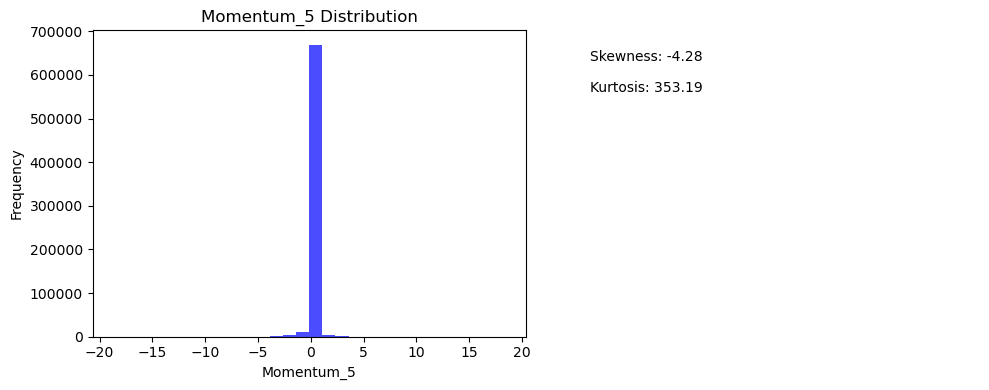

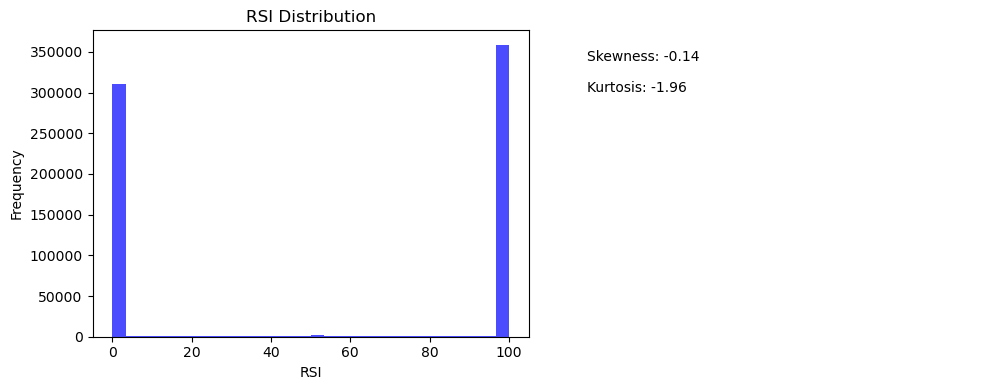

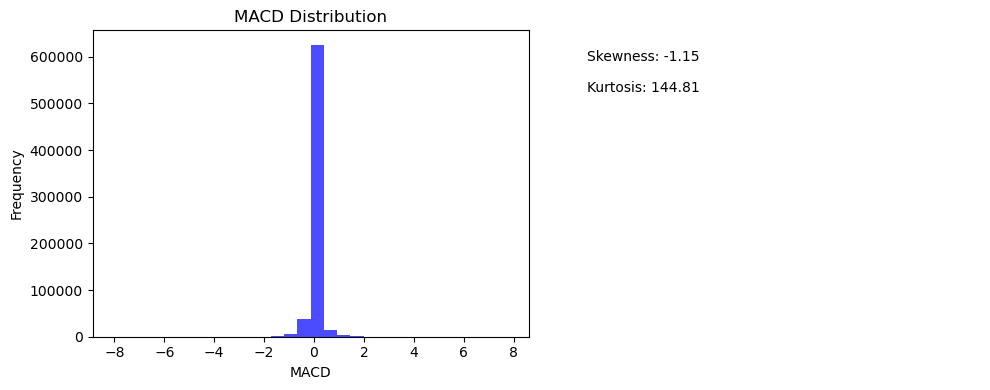

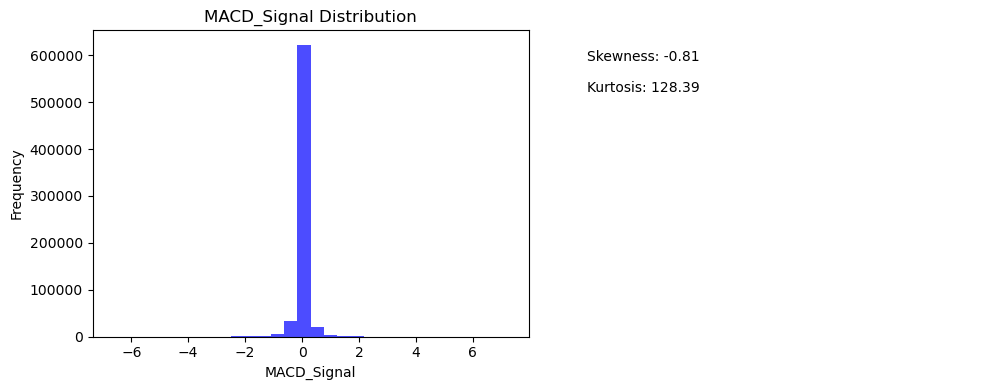

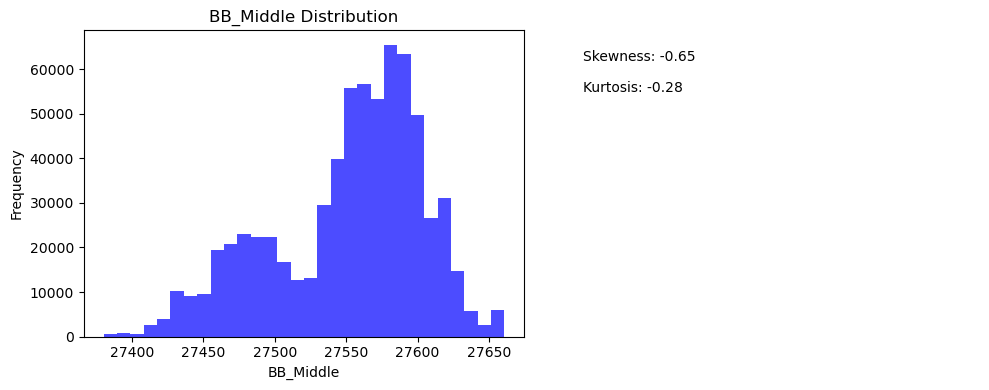

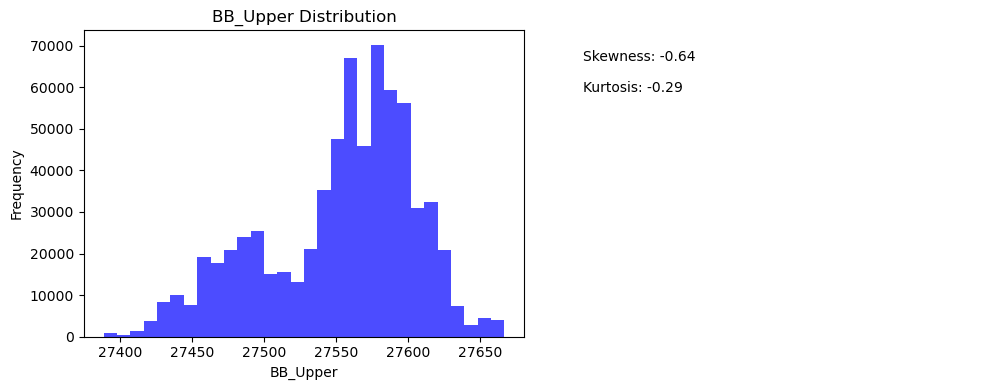

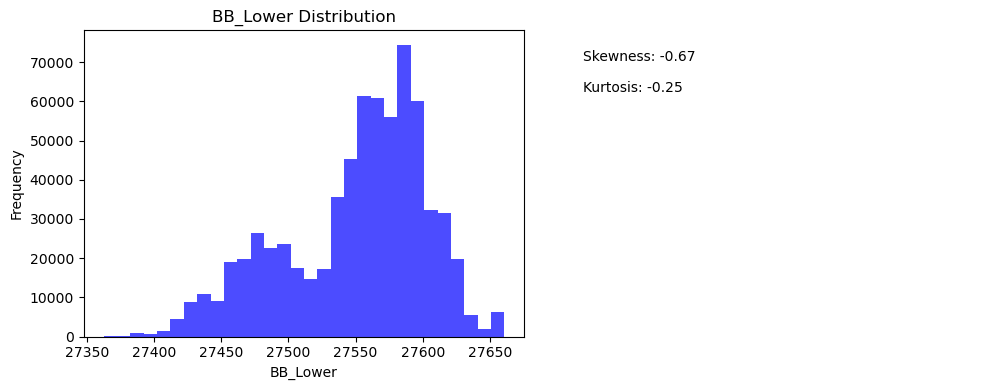

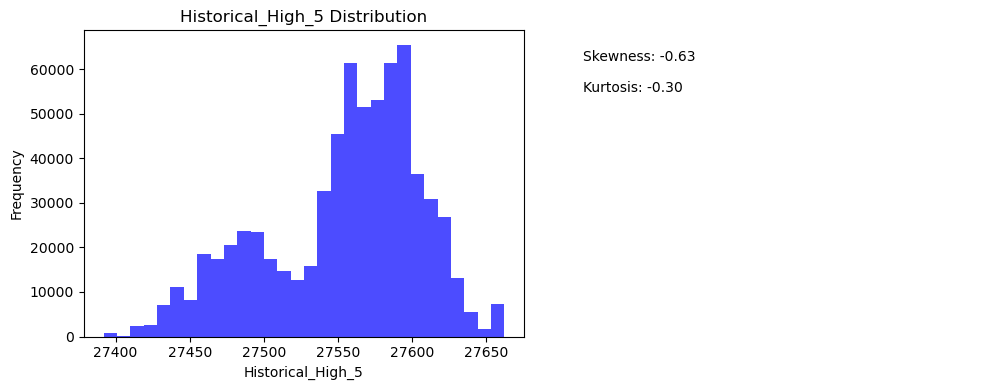

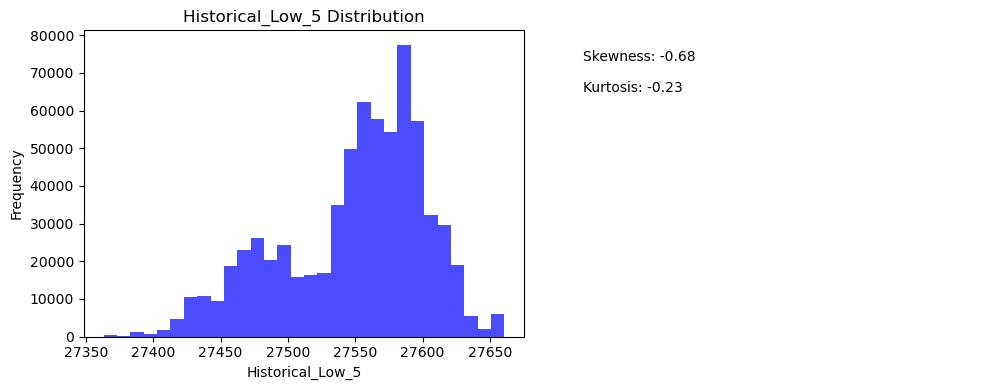

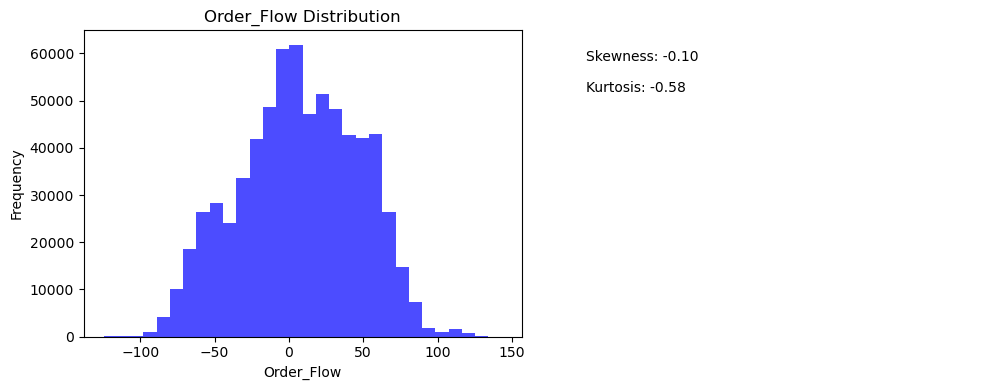

Skipping Volume_ROC due to invalid values


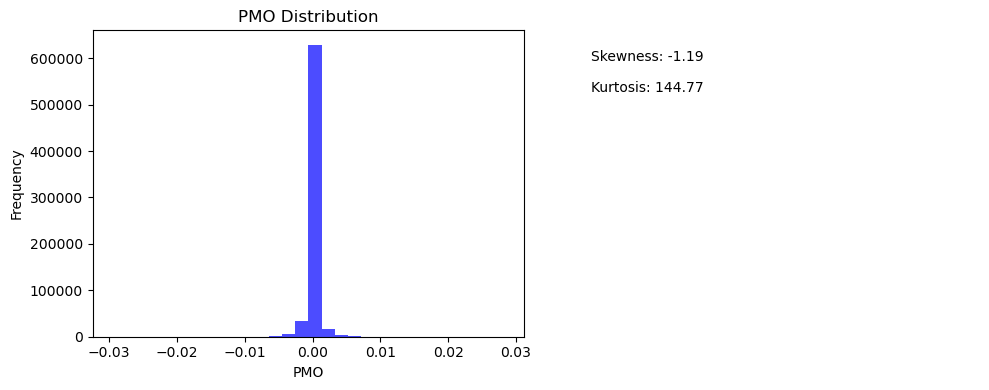

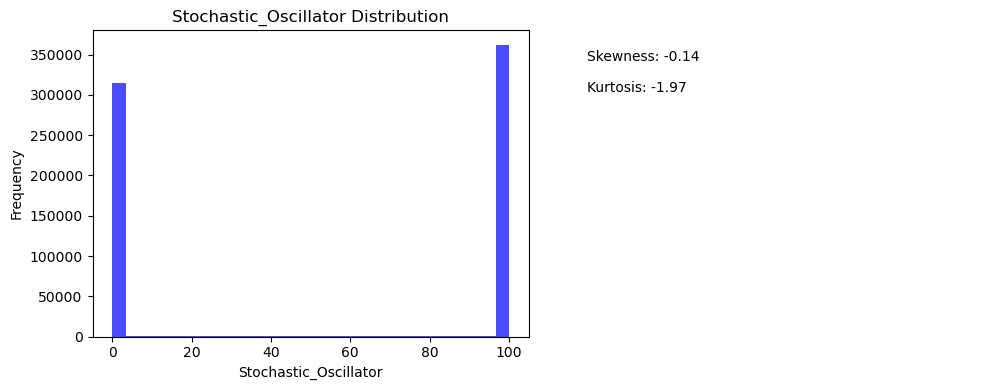

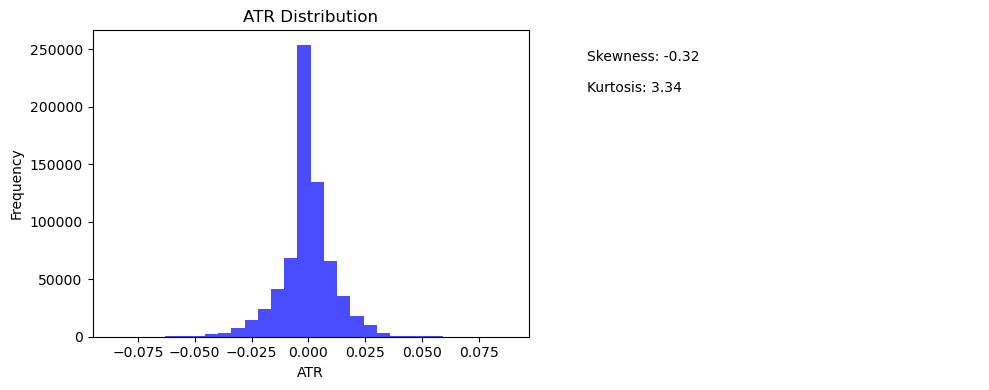

Skipping Price_to_Volume due to invalid values


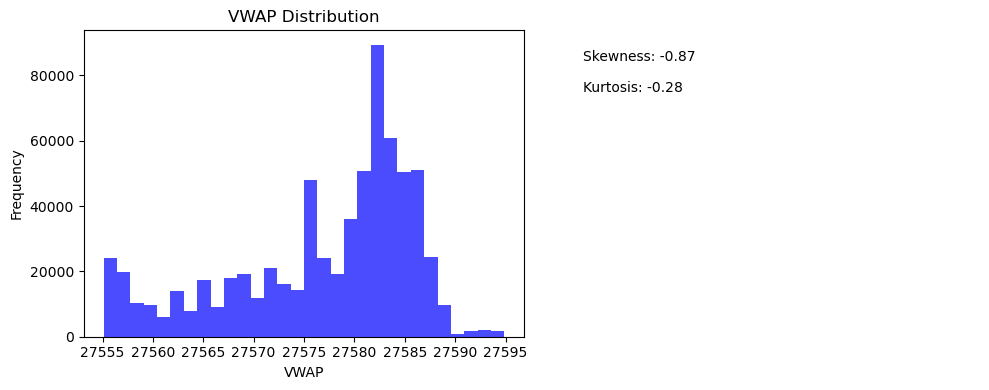

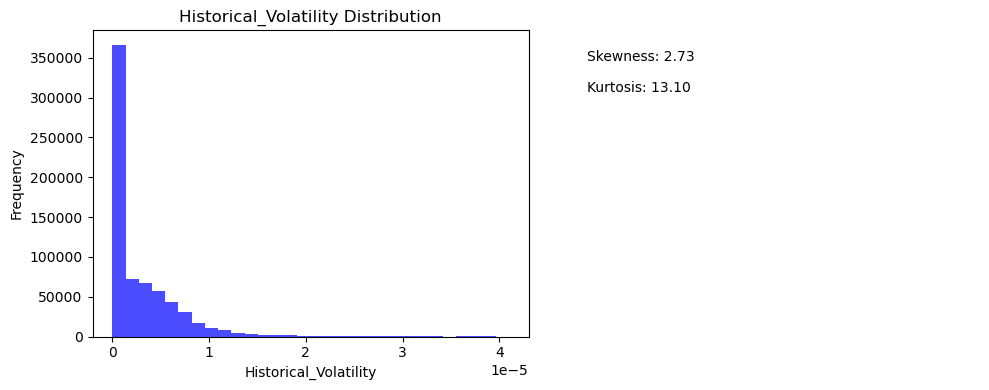

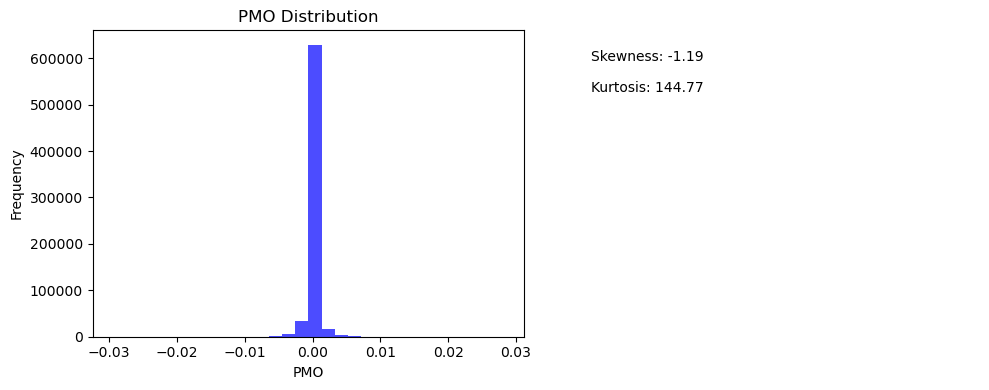

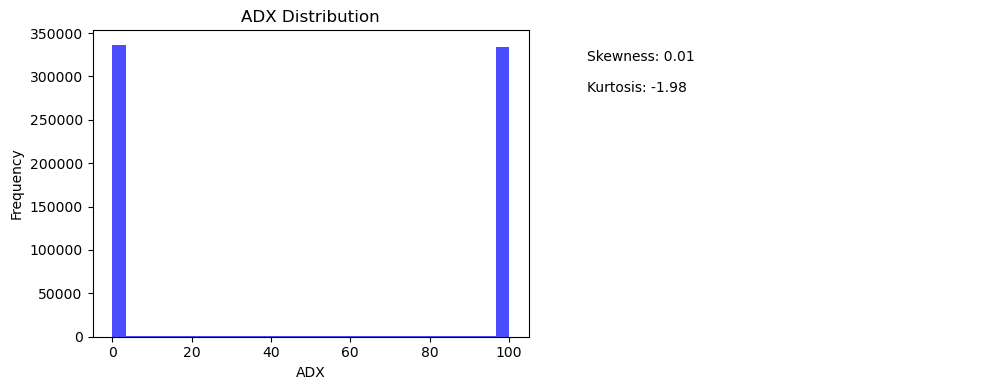

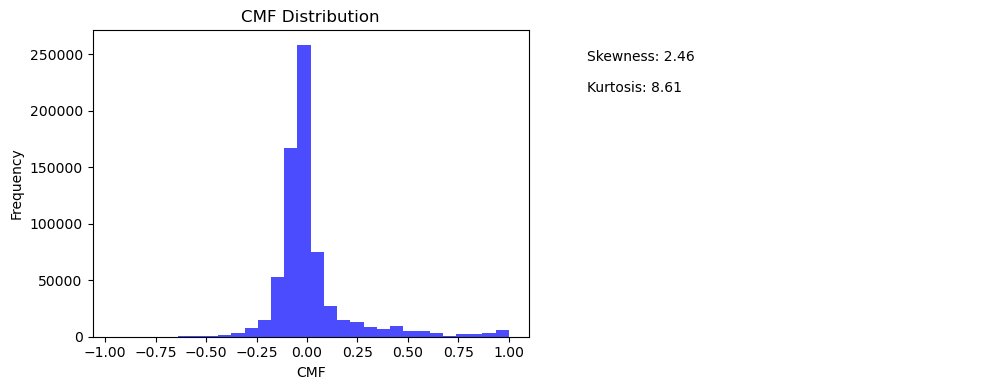

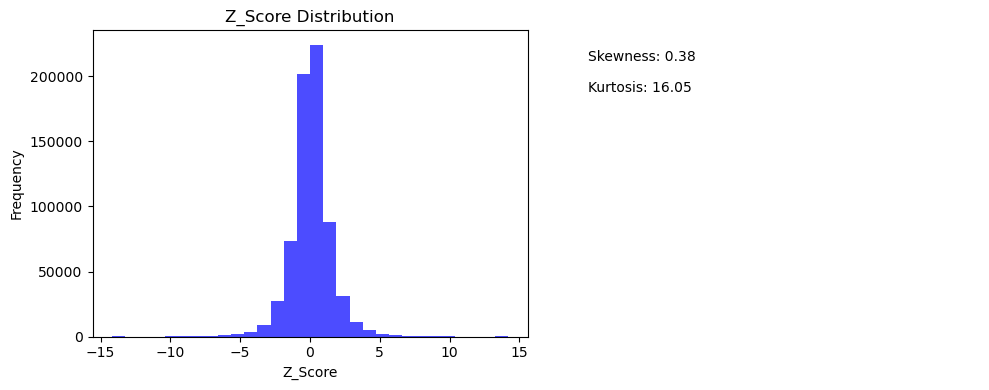

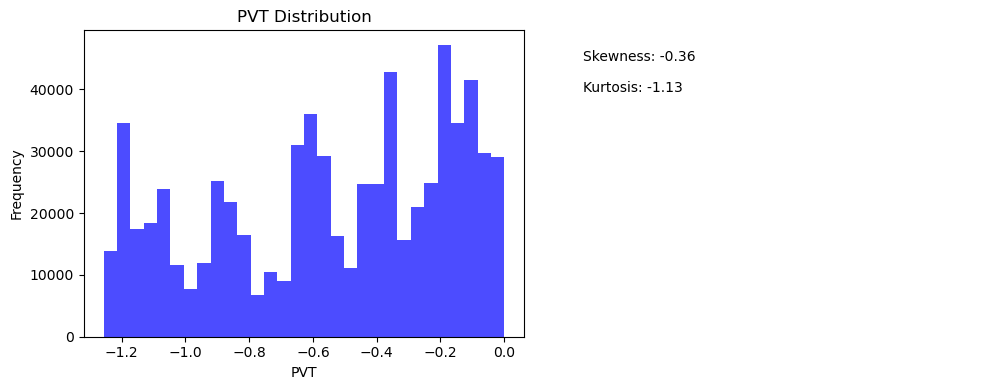

Skipping EoM due to invalid values


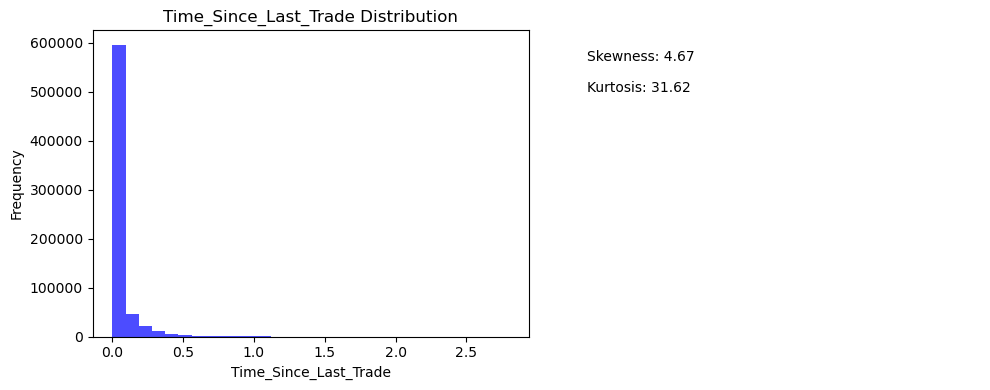

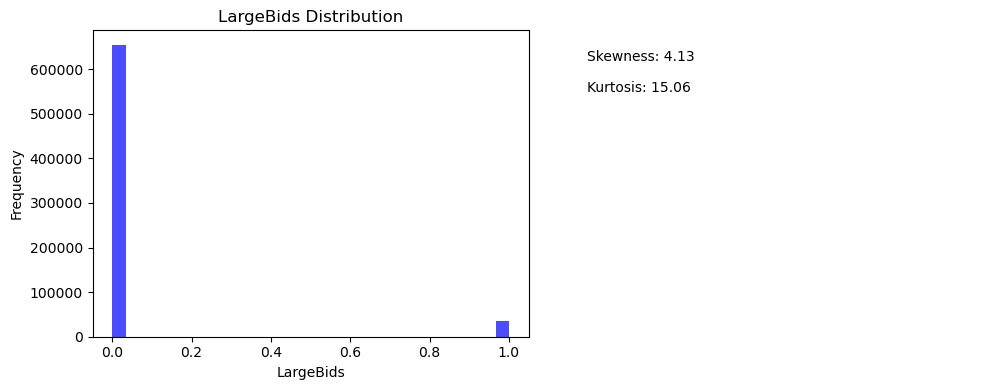

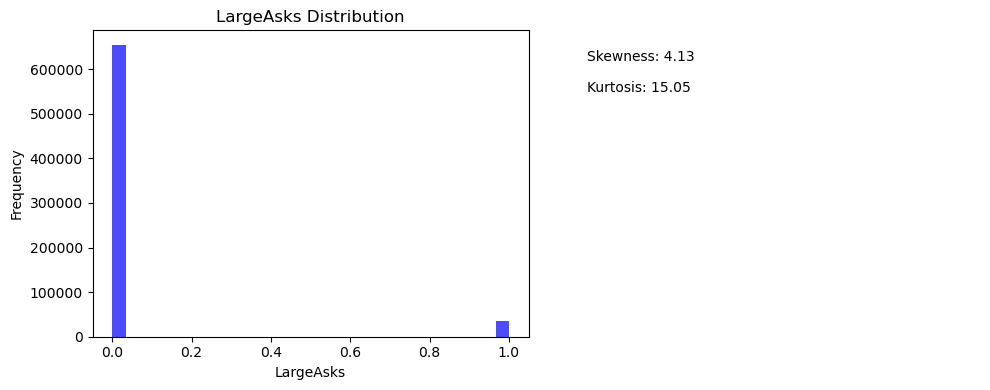

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# Suppose orderbook_history is your DataFrame

# List of features
features = [
    "Spread", "Spread_MA5", "Volatility", "Price_MA5", "BuySellPressure", 
    "OrderBookImbalance", "PriceRateOfChange", "Slippage", "MA10", "MA20", 
    "MA50", "Momentum_5", "RSI", "MACD", "MACD_Signal", "BB_Middle", 
    "BB_Upper", "BB_Lower", "Historical_High_5", "Historical_Low_5", 
    "Order_Flow", "Volume_ROC", "PMO", "Stochastic_Oscillator", "ATR", 
    "Price_to_Volume", "VWAP", "Historical_Volatility", "PMO", "ADX", 
    "CMF", "Z_Score", "PVT", "EoM", "Time_Since_Last_Trade", "LargeBids", 
    "LargeAsks"
]

# Calculate skewness and kurtosis for each feature and plot their distributions
for feature in features:
    data = orderbook_history[feature].dropna()
    
    # Check for infinite or NaN values
    if data.isin([np.nan, np.inf, -np.inf]).any():
        print(f"Skipping {feature} due to invalid values")
        continue
    
    # Calculate skewness and kurtosis
    skewness = skew(data)
    kurt = kurtosis(data)
    
    # Plot the distribution
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(data, bins=30, color='blue', alpha=0.7)
    plt.title(f'{feature} Distribution')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    plt.text(0.1, 0.9, f'Skewness: {skewness:.2f}', transform=plt.gca().transAxes)
    plt.text(0.1, 0.8, f'Kurtosis: {kurt:.2f}', transform=plt.gca().transAxes)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


In [5]:
# Supposons que 'orderbook_history' est votre DataFrame

# Calcul de la moyenne mobile et de l'écart-type pour 'BestAskPrice'
orderbook_history['Mean'] = orderbook_history['BestAskPrice'].rolling(window=50).mean()
orderbook_history['Std'] = orderbook_history['BestAskPrice'].rolling(window=50).std()

# Calcul du Z-Score
orderbook_history['Z-Score'] = (orderbook_history['BestAskPrice'] - orderbook_history['Mean']) / orderbook_history['Std']

# Génération des signaux d'achat et de vente
orderbook_history['Signal'] = np.where(orderbook_history['Z-Score'] > 2, 'Sell', 
                                       np.where(orderbook_history['Z-Score'] < -2, 'Buy', 'Neutral'))

# Affichage des signaux d'achat et de vente
print(orderbook_history[['Timestamp', 'BestAskPrice', 'Z-Score', 'Signal']])


                     Timestamp  BestAskPrice  Z-Score   Signal
0      2023-10-03 03:57:17.728       27581.4      NaN  Neutral
1      2023-10-03 03:57:18.018       27581.4      NaN  Neutral
2      2023-10-03 03:57:18.258       27581.4      NaN  Neutral
3      2023-10-03 03:57:18.367       27581.4      NaN  Neutral
4      2023-10-03 03:57:18.417       27581.4      NaN  Neutral
...                        ...           ...      ...      ...
688626 2023-10-03 13:36:57.617       27497.9      NaN  Neutral
688627 2023-10-03 13:36:57.628       27497.9      NaN  Neutral
688628 2023-10-03 13:36:57.637       27497.9      NaN  Neutral
688629 2023-10-03 13:36:57.647       27497.9      NaN  Neutral
688630 2023-10-03 13:36:57.677       27497.9      NaN  Neutral

[688631 rows x 4 columns]


In [ ]:
# Calcul de la différence entre le Spread et sa moyenne mobile sur 5 périodes
orderbook_history['Spread_Diff'] = orderbook_history['Spread'] - orderbook_history['Spread_MA5']

# Génération des signaux d'achat et de vente
orderbook_history['Signal'] = np.where(orderbook_history['Spread_Diff'] > 1, 'Buy', 
                                       np.where(orderbook_history['Spread_Diff'] < -1, 'Sell', 'Neutral'))


In [9]:
# Génération des signaux d'achat et de vente
orderbook_history['Signal'] = np.where(orderbook_history['Momentum_5'] > 1, 'Buy', 
                                       np.where(orderbook_history['Momentum_5'] < -1, 'Sell', 'Neutral'))


In [ ]:
# Génération des signaux d'achat et de vente
orderbook_history['Signal'] = np.where(orderbook_history['RSI'] < 30, 'Buy', 
                                       np.where(orderbook_history['RSI'] > 70, 'Sell', 'Neutral'))


In [ ]:
# Génération des signaux d'achat et de vente
orderbook_history['Signal'] = np.where(orderbook_history['MACD'] > orderbook_history['MACD_Signal'], 'Buy', 
                                       np.where(orderbook_history['MACD'] < orderbook_history['MACD_Signal'], 'Sell', 'Neutral'))


In [ ]:
# Génération des signaux d'achat et de vente
orderbook_history['Signal'] = np.where(orderbook_history['BestAskPrice'] > orderbook_history['BB_Upper'], 'Sell',
                                       np.where(orderbook_history['BestAskPrice'] < orderbook_history['BB_Lower'], 'Buy', 'Neutral'))


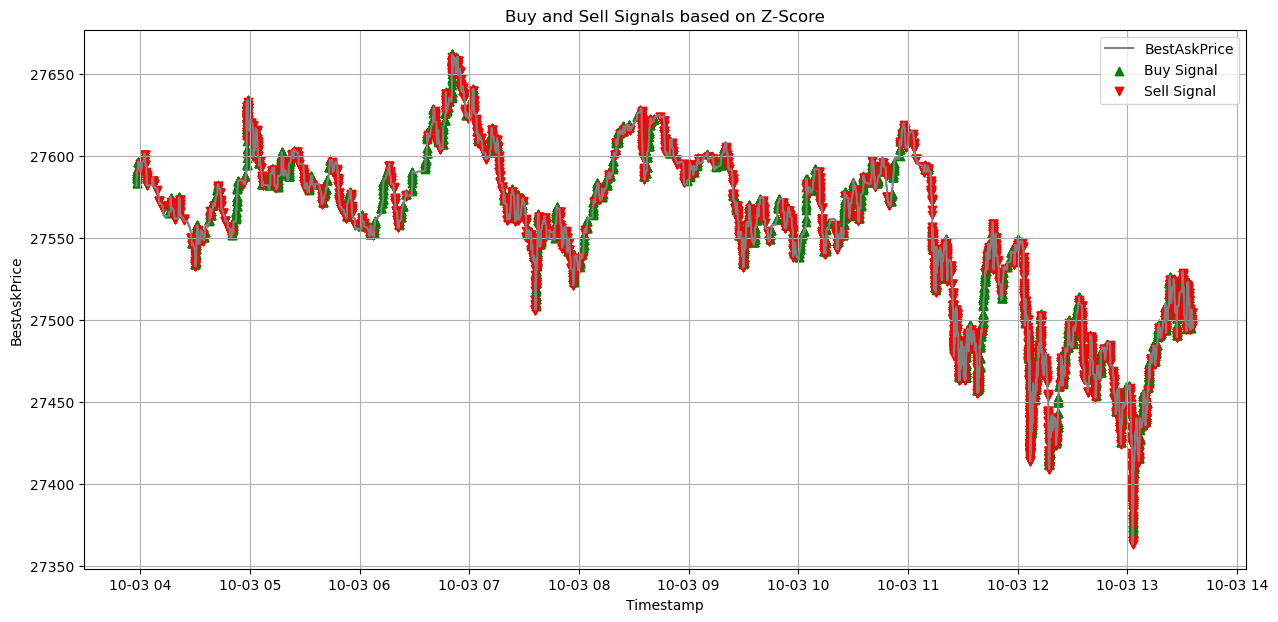

In [10]:
import matplotlib.pyplot as plt

# Filtrons les lignes où le Z-Score est NaN
filtered_data = orderbook_history.dropna(subset=['Z-Score'])

# Créons un graphique pour visualiser le prix et les signaux d'achat/vente
plt.figure(figsize=(15, 7))

plt.plot(filtered_data['Timestamp'], filtered_data['BestAskPrice'], label='BestAskPrice', color='gray')
plt.scatter(filtered_data['Timestamp'][filtered_data['Signal'] == 'Buy'], filtered_data['BestAskPrice'][filtered_data['Signal'] == 'Buy'], label='Buy Signal', marker='^', color='g', alpha=1)
plt.scatter(filtered_data['Timestamp'][filtered_data['Signal'] == 'Sell'], filtered_data['BestAskPrice'][filtered_data['Signal'] == 'Sell'], label='Sell Signal', marker='v', color='r', alpha=1)

plt.title('Buy and Sell Signals based on Momentum')
plt.xlabel('Timestamp')
plt.ylabel('BestAskPrice')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
initial_capital = 10000  # 10,000 USD
capital = initial_capital
position = 0
entry_price = 0
transaction_fee = 0.0002  # 0.02% par transaction
trade_count = 0
win_count = 0
previous_balance = capital

balances = []

for index, row in filtered_data.iterrows():
    if row['Signal'] == 'Buy' and capital > 0:
        trade_count += 1
        entry_price = row['BestAskPrice']
        position = capital / entry_price
        capital -= position * entry_price
        capital -= capital * transaction_fee  # Frais de transaction
    elif row['Signal'] == 'Sell' and position > 0:
        trade_count += 1
        exit_price = row['BestAskPrice']
        capital += position * exit_price
        capital -= capital * transaction_fee  # Frais de transaction
        if (position * exit_price) > (position * entry_price):
            win_count += 1
        position = 0
    balances.append(capital + (position * row['BestAskPrice']))

# Calcul des statistiques
final_balance = balances[-1]
performance = (final_balance - initial_capital) / initial_capital
win_rate = win_count / trade_count
drawdown = (min(balances) - initial_capital) / initial_capital

print(f"Performance: {performance * 100:.2f}%")
print(f"Win Rate: {win_rate * 100:.2f}%")
print(f"Drawdown: {drawdown * 100:.2f}%")


Performance: 2.35%
Win Rate: 39.30%
Drawdown: 0.00%


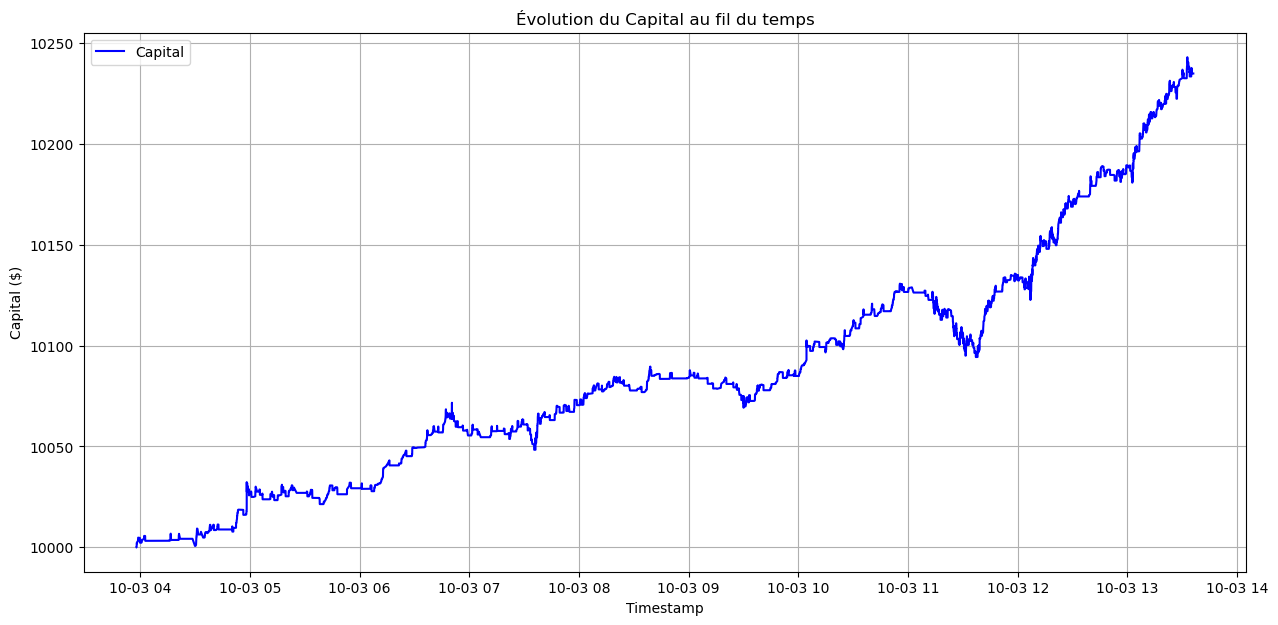

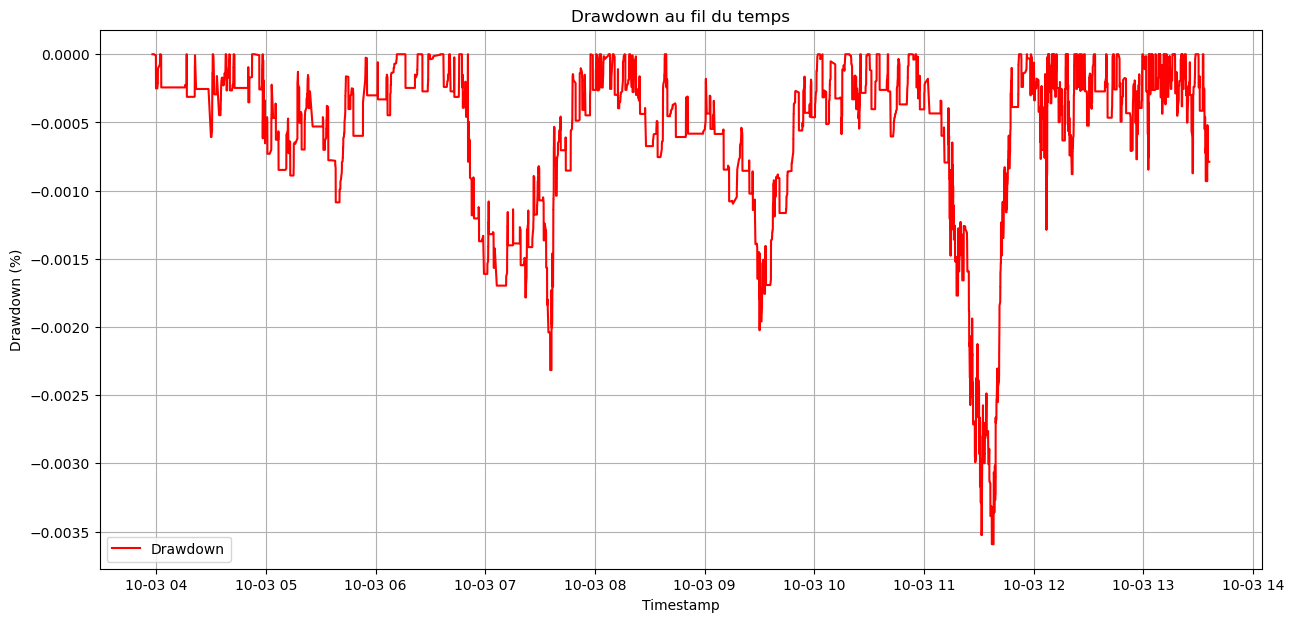

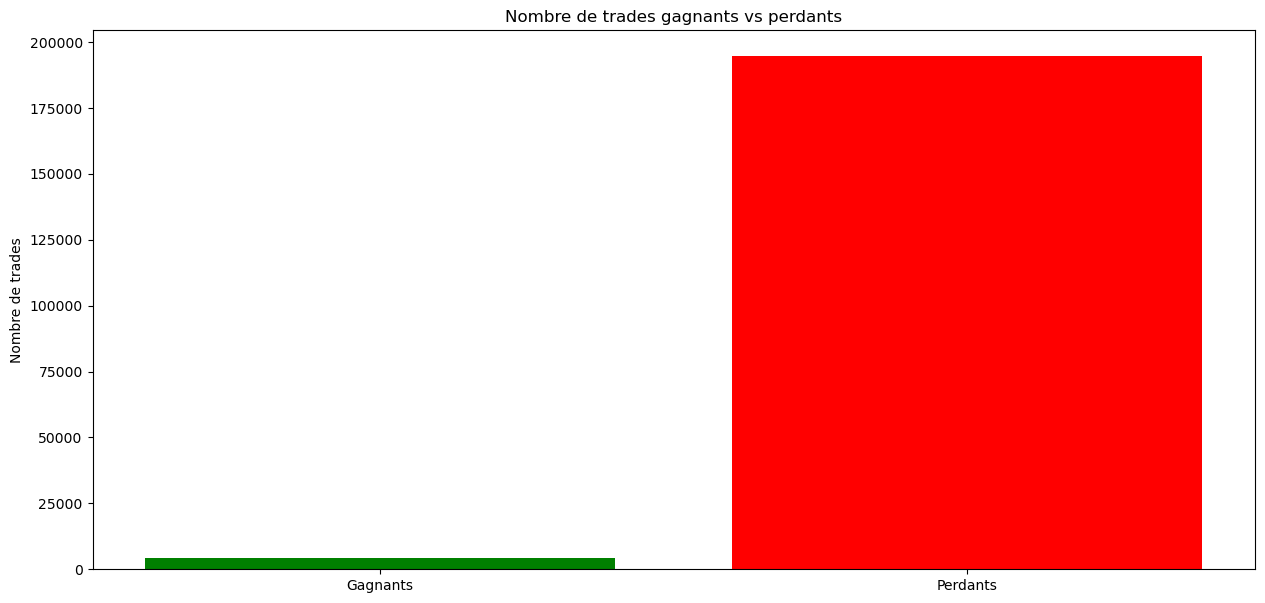

In [12]:
import matplotlib.pyplot as plt

# 1. Évolution du capital
plt.figure(figsize=(15, 7))
plt.plot(filtered_data['Timestamp'], balances, label='Capital', color='blue')
plt.title('Évolution du Capital au fil du temps')
plt.xlabel('Timestamp')
plt.ylabel('Capital ($)')
plt.legend()
plt.grid(True)
plt.show()

# 2. Drawdown
drawdowns = [(balance - max(balances[:index+1])) / max(balances[:index+1]) for index, balance in enumerate(balances)]
plt.figure(figsize=(15, 7))
plt.plot(filtered_data['Timestamp'], drawdowns, label='Drawdown', color='red')
plt.title('Drawdown au fil du temps')
plt.xlabel('Timestamp')
plt.ylabel('Drawdown (%)')
plt.legend()
plt.grid(True)
plt.show()

# 3. Nombre de trades gagnants/perdants
wins_losses = [1 if balances[i] > balances[i-1] else -1 for i in range(1, len(balances))]
plt.figure(figsize=(15, 7))
plt.bar(['Gagnants', 'Perdants'], [wins_losses.count(1), wins_losses.count(-1)], color=['green', 'red'])
plt.title('Nombre de trades gagnants vs perdants')
plt.ylabel('Nombre de trades')
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set seaborn style
sns.set_style("ticks")

# Extract the data
timestamps = orderbook_history["Timestamp"]

# List of columns to plot
columns_to_plot = orderbook_history.columns[4:]

# Plotting the data using seaborn
fig, axs = plt.subplots(len(columns_to_plot), 1, figsize=(14, 3*len(columns_to_plot)), constrained_layout=True)

for i, col in enumerate(columns_to_plot):
    sns.lineplot(x=timestamps, y=orderbook_history[col], ax=axs[i], color=sns.color_palette("tab10")[i])
    axs[i].set_title(f"{col} vs Time")
    axs[i].set_ylabel(col)
    axs[i].set_xlabel("Timestamp")

plt.show()
